# METYIS CHALLENGE

Descripción del dataset:

There are 6820 movies in the dataset (220 movies per year, 1986-2016). Each movie has the following attributes:

- budget: the budget of a movie. Some movies don't have this, so it appears as 0

- company: the production company

- country: country of origin

- director: the director

- genre: main genre of the movie.

- gross: revenue of the movie

- name: name of the movie

- rating: rating of the movie (R, PG, etc.)

- released: release date (YYYY-MM-DD)

- runtime: duration of the movie

- score: IMDb user rating

- votes: number of user votes

- star: main actor/actress

- writer: writer of the movie

- year: year of release

## SET ENVIRONMENT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas_profiling import ProfileReport
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant
from scipy import stats
import klib
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import re
import calendar
sns.set()

## GET DATA 

In [2]:
# getting data from file
df_raw = pd.read_csv('../data/movies.csv')
df_raw.head()

budget                                 company country        director  \
0   8000000.0           Columbia Pictures Corporation     USA      Rob Reiner   
1   6000000.0                      Paramount Pictures     USA     John Hughes   
2  15000000.0                      Paramount Pictures     USA      Tony Scott   
3  18500000.0  Twentieth Century Fox Film Corporation     USA   James Cameron   
4   9000000.0                    Walt Disney Pictures     USA  Randal Kleiser   

       genre        gross                      name rating    released  \
0  Adventure   52287414.0               Stand by Me      R  1986-08-22   
1     Comedy   70136369.0  Ferris Bueller's Day Off  PG-13  1986-06-11   
2     Action  179800601.0                   Top Gun     PG  1986-05-16   
3     Action   85160248.0                    Aliens      R  1986-07-18   
4  Adventure   18564613.0   Flight of the Navigator     PG  1986-08-01   

   runtime  score               star   votes         writer  year  
0       89    8.1        Wil Wheaton  299174   Stephen King  1986  
1      103    7.8  Matthew Broderick  264740    John Hughes  1986  
2      110    6.9         Tom Cruise  236909       Jim Cash  1986  
3      137    8.4   Sigourney Weaver  540152  James Cameron  1986  
4       90    6.9        Joey Cramer   36636  Mark H. Baker  1986

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   budget    6820 non-null   float64
 1   company   6820 non-null   object 
 2   country   6820 non-null   object 
 3   director  6820 non-null   object 
 4   genre     6820 non-null   object 
 5   gross     6820 non-null   float64
 6   name      6820 non-null   object 
 7   rating    6820 non-null   object 
 8   released  6820 non-null   object 
 9   runtime   6820 non-null   int64  
 10  score     6820 non-null   float64
 11  star      6820 non-null   object 
 12  votes     6820 non-null   int64  
 13  writer    6820 non-null   object 
 14  year      6820 non-null   int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 799.3+ KB


In [4]:
# own functions to perform exploratory data analysis

def plot_histograms(df, figsize=(12,4)):
    """
    Plots a histogram for each one of the numerical varaibles in the dataset
    """
    # excludes categorical and datetimes variables
    num_features = df.select_dtypes(exclude=['object','datetime'])
    for feat in num_features.columns:
        fig, ax = plt.subplots(1,2, figsize=figsize)
        # histogram
        sns.histplot(num_features, x=feat, kde=True, ax=ax[0]) 
        ax[0].set(title='Histogram')
        # cumulative distribution function
        sns.histplot(num_features, x=feat, element='step', fill=False,
                     cumulative=True, stat='density', common_norm=False, ax=ax[1])
        ax[1].set(title='CDF')
        plt.suptitle(feat, fontsize=20)        
        plt.tight_layout()    
        
        
def plot_boxplot(df, figsize=(5,5)):
    """
    Plots a boxplot for each one of the numerical varaibles in the dataset
    """
    # excludes categorical and datetimes variables
    num_features = df.select_dtypes(exclude=['object','datetime'])
    for feat in num_features.columns:
        fig, ax = plt.subplots(figsize=figsize)
        sns.boxplot(y=num_features[feat]) 
        plt.tight_layout()  
        

def check_normality(df, alpha=0.05):
    """
    Tests the null hypothesis that a sample comes from a normal distribution
    
    Returns
    --------
    list with the names of normally distributed variables
    """
    
    # excludes categorical and datetimes variables
    num_features = df.select_dtypes(exclude=['object','datetime'])
    l_normal = []
    for feat in num_features.columns:    
        _, pvalue = stats.normaltest(df[feat].dropna()) # avoid eror if nans
        if pvalue >= alpha:
            l_normal.append(feat)
    return l_normal


def calculate_vif_(X, thresh=5):
    """
    Returns the dataset with features without collinearity
    """
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## EDA

In [5]:
seed = 42 # seed for allow reproducible analysis

In [6]:
df = df_raw.copy()
df = df.sample(frac=1, random_state=seed)

In [7]:
# replaces 0 by nans according to the description of the variable
df['budget'] = df['budget'].replace(0, np.nan)

In [8]:
# missing values
df.isna().sum()

budget      2182
company        0
country        0
director       0
genre          0
gross          0
name           0
rating         0
released       0
runtime        0
score          0
star           0
votes          0
writer         0
year           0
dtype: int64

In [9]:
# changes released variable  to datetime
df['released'] = pd.to_datetime(df['released'])
# checking types
df.dtypes

budget             float64
company             object
country             object
director            object
genre               object
gross              float64
name                object
rating              object
released    datetime64[ns]
runtime              int64
score              float64
star                object
votes                int64
writer              object
year                 int64
dtype: object

In [10]:
# range of released dates
start_date = df['released'].min().strftime('%d-%m-%Y')
final_date = df['released'].max().strftime('%d-%m-%Y')
print(f"There are films from {start_date} to {final_date}.")

There are films from 10-01-1986 to 23-11-2017.


In [11]:
# description of numerical variables
df.describe()

budget         gross     runtime        score         votes  \
count  4.638000e+03  6.820000e+03  6820.00000  6820.000000  6.820000e+03   
mean   3.614560e+07  3.349783e+07   106.55132     6.374897  7.121952e+04   
std    3.996947e+07  5.819760e+07    18.02818     1.003142  1.305176e+05   
min    6.000000e+03  7.000000e+01    50.00000     1.500000  2.700000e+01   
25%    1.000000e+07  1.515839e+06    95.00000     5.800000  7.665250e+03   
50%    2.300000e+07  1.213568e+07   102.00000     6.400000  2.589250e+04   
75%    4.600000e+07  4.006534e+07   115.00000     7.100000  7.581225e+04   
max    3.000000e+08  9.366622e+08   366.00000     9.300000  1.861666e+06   

              year  
count  6820.000000  
mean   2001.000293  
std       8.944501  
min    1986.000000  
25%    1993.000000  
50%    2001.000000  
75%    2009.000000  
max    2016.000000

Exploring extreme values in runtime:

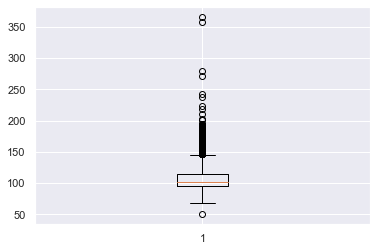

In [12]:
plt.boxplot(df['runtime']);

In [13]:
# observarions with runtime higher than 5 hours
df.loc[df['runtime']>300]

budget    company country               director  genre      gross  \
395      NaN      Sands      UK       Christine Edzard  Drama  1025228.0   
3890     NaN  BiBi Film   Italy  Marco Tullio Giordana  Drama   254224.0   

                   name rating   released  runtime  score             star  \
395       Little Dorrit      G 1988-10-21      357    7.5     Derek Jacobi   
3890  The Best of Youth      R 2003-06-20      366    8.5  Luigi Lo Cascio   

      votes            writer  year  
395     886   Charles Dickens  1987  
3890  17585  Sandro Petraglia  2003

The Best of Youth and Little Dorrit according filmaffinity are series and not films, so we exlude both observations because they do not come from the same distribution of the population of interest (films).

In [14]:
# dropping series in the dataset
df.drop(df.loc[df['runtime']>300].index, inplace=True)

In [15]:
# description of categorical variables
df.describe(include='object')

company country     director   genre    name rating  \
count                 6818    6818         6818    6818    6818   6818   
unique                2177      57         2757      17    6729     13   
top     Universal Pictures     USA  Woody Allen  Comedy  Hamlet      R   
freq                   302    4872           33    2080       3   3391   

                star       writer  
count           6818         6818  
unique          2503         4198  
top     Nicolas Cage  Woody Allen  
freq              42           32

In [16]:
# quick EDA
profile = ProfileReport(df, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

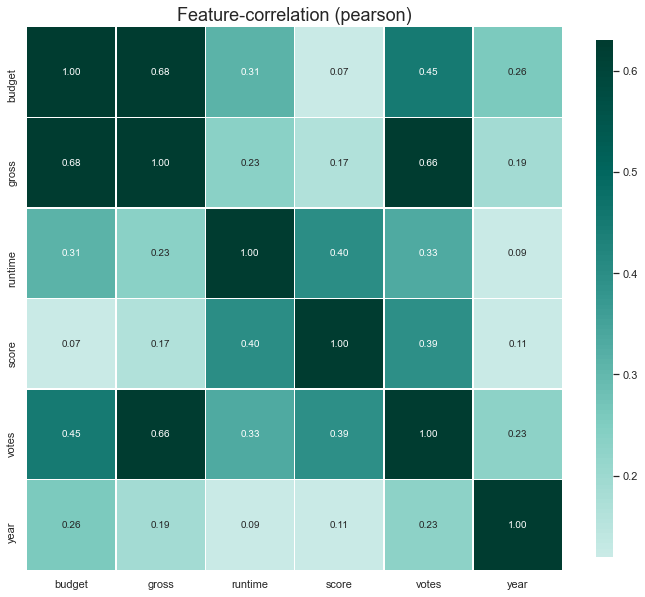

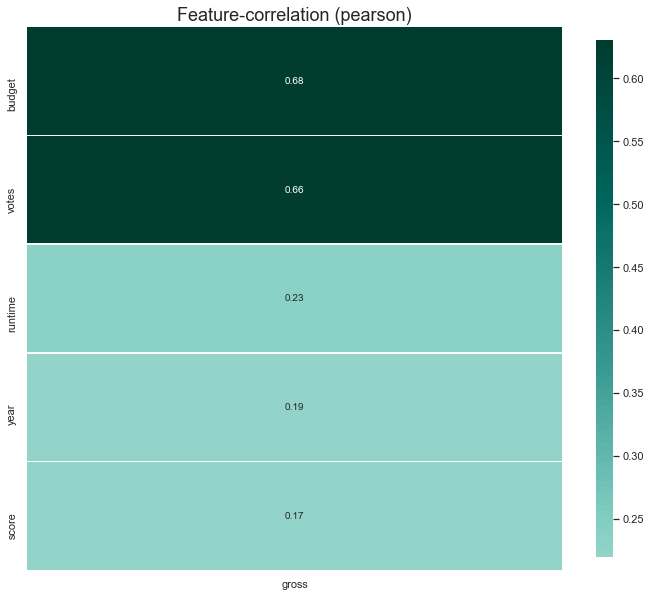

In [17]:
# correlation between variables
klib.corr_plot(df, mask=False);
# correlation with target value
klib.corr_plot(df, target='gross');

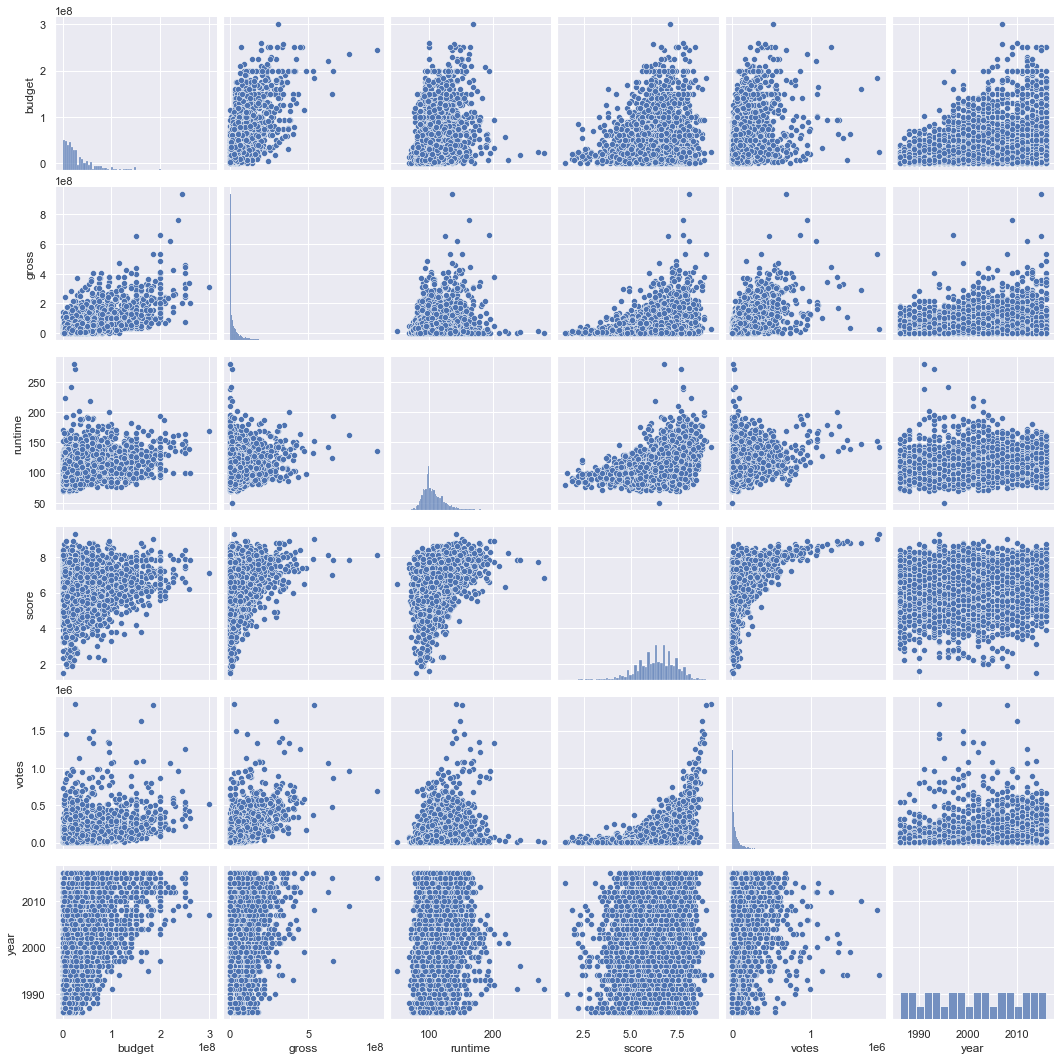

In [18]:
# scatterplots between variables
sns.pairplot(df)

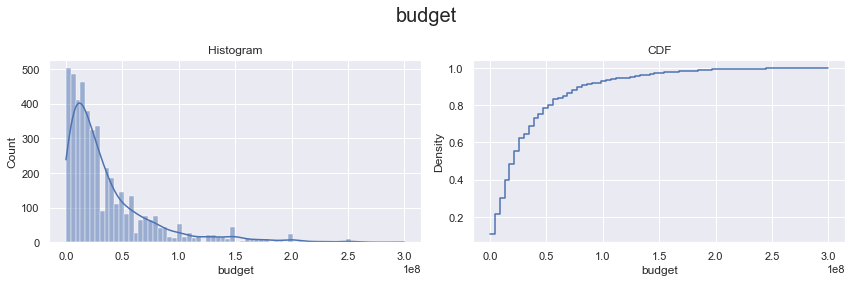

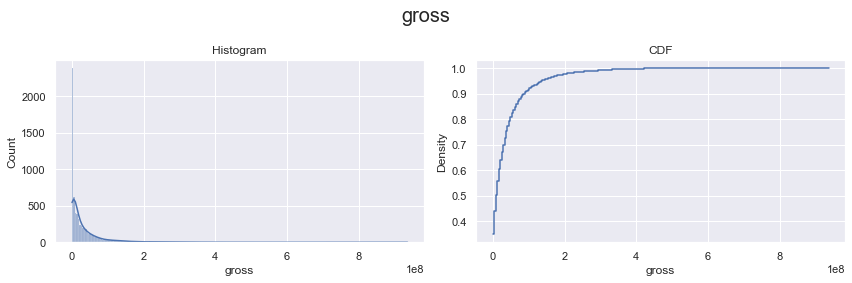

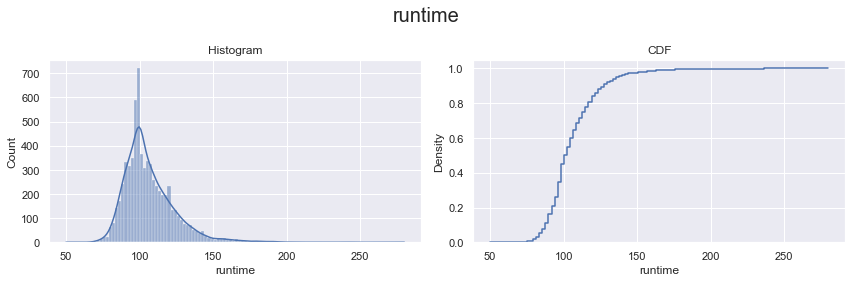

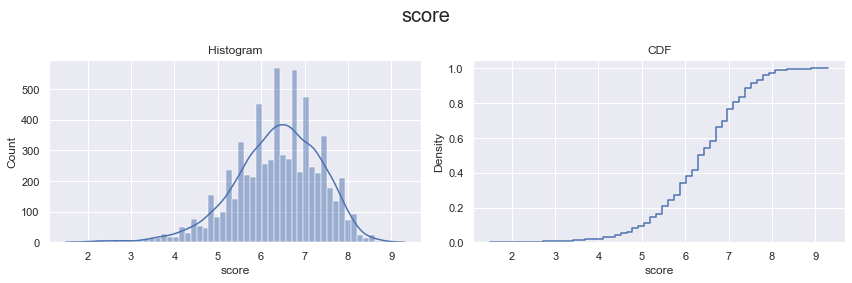

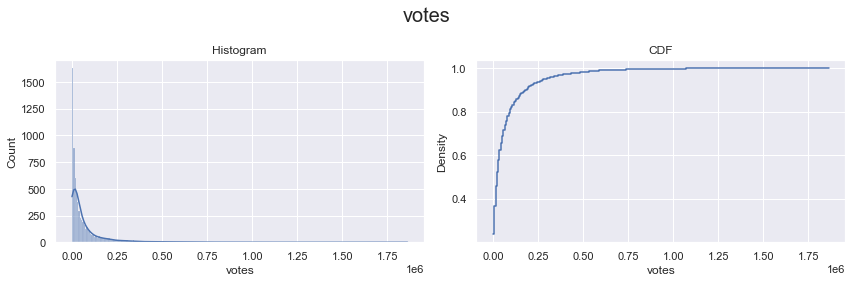

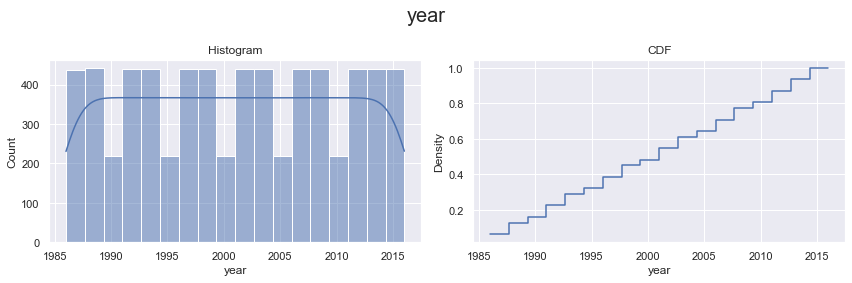

In [19]:
# distributions of variables
plot_histograms(df)

In [20]:
# checking variables normaly distributed
check_normality(df, 0.05)

[]

Summary:

- It does not appear that there is any wrong or weird value in the data.
- None of the distributions pass the normality test, despite the fact that runtime and score variables are visually closer to a normal distribution than the rest.
- Budget, gross and votes variables are right-skewed.
- Apply log-transformation to numerical variables if needed (linear models usually work better on normalized data)

## FEATURE ENGINEERING

In [21]:
# log-transformations to reduce the skewness of the data
features = ['budget', 'gross', 'votes'] 
for feat in features:
    featname = f"{feat}_log"
    df[featname] = np.log(df[feat])

In [22]:
# adding month as a new categorical feature
df['month'] = df['released'].dt.month
df['month'] = df['month'].astype('str')

In [23]:
# adding a new variable score*votes representing powerful notes
df['popularity'] = df['score'] * df['votes']
# log-transform since it is right-skewed
df['popularity_log'] = np.log(df['score'] * df['votes'])

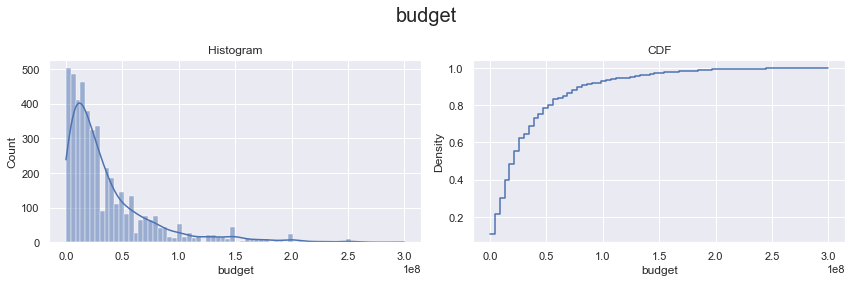

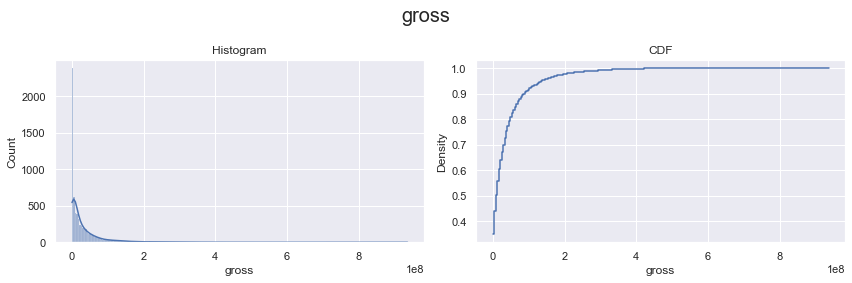

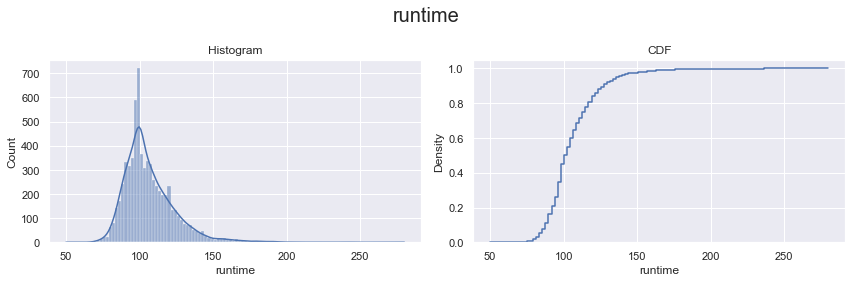

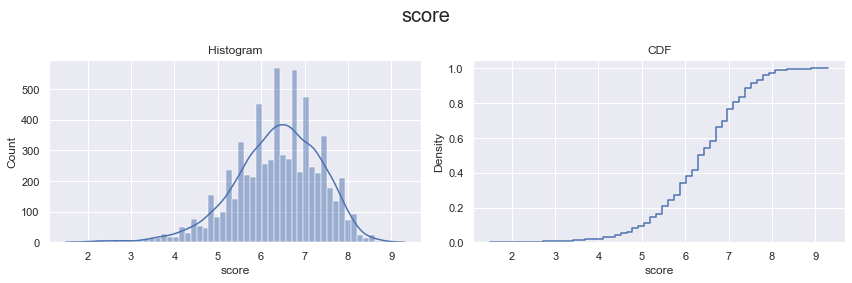

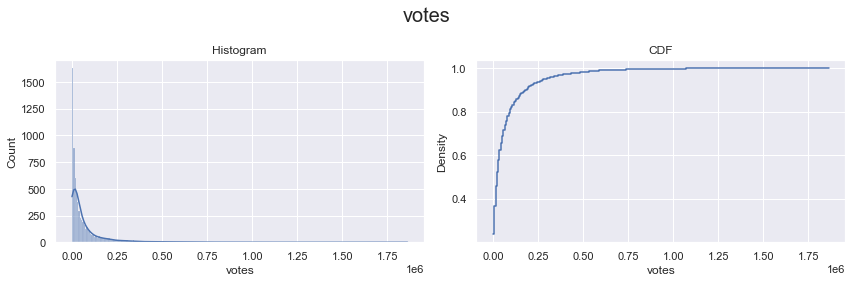

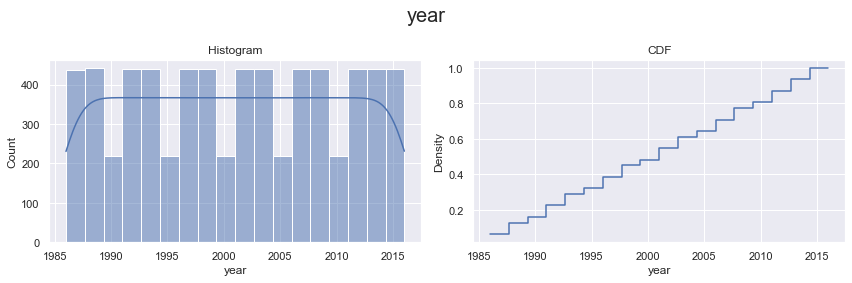

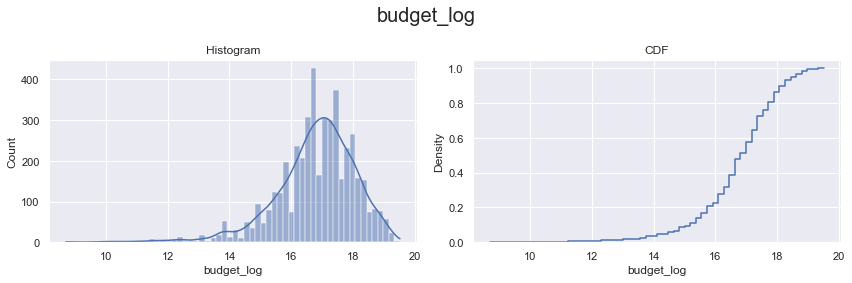

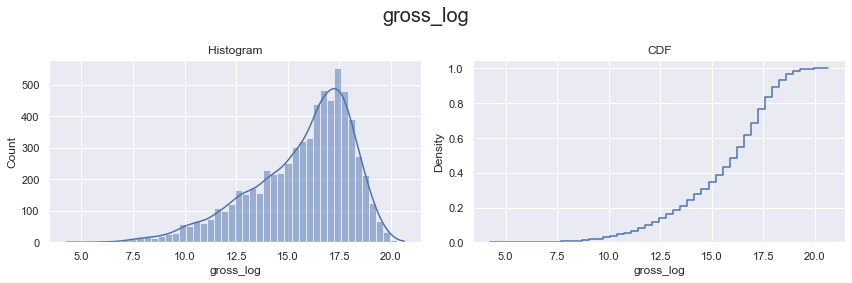

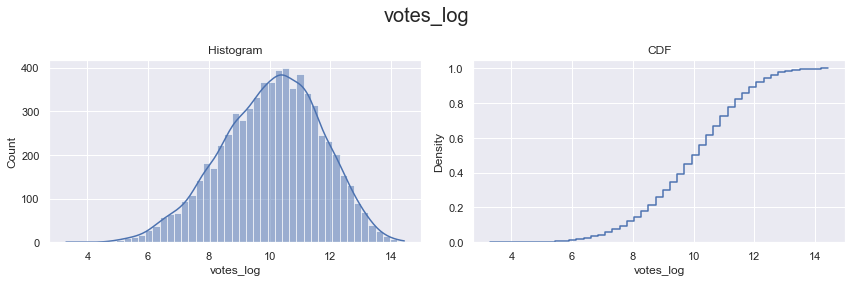

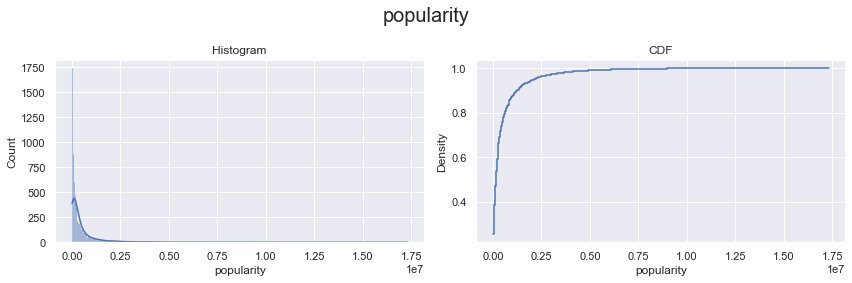

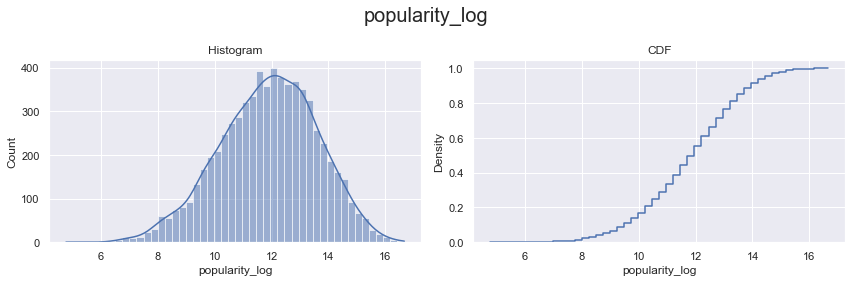

In [24]:
# new distributions with transformations
plot_histograms(df)

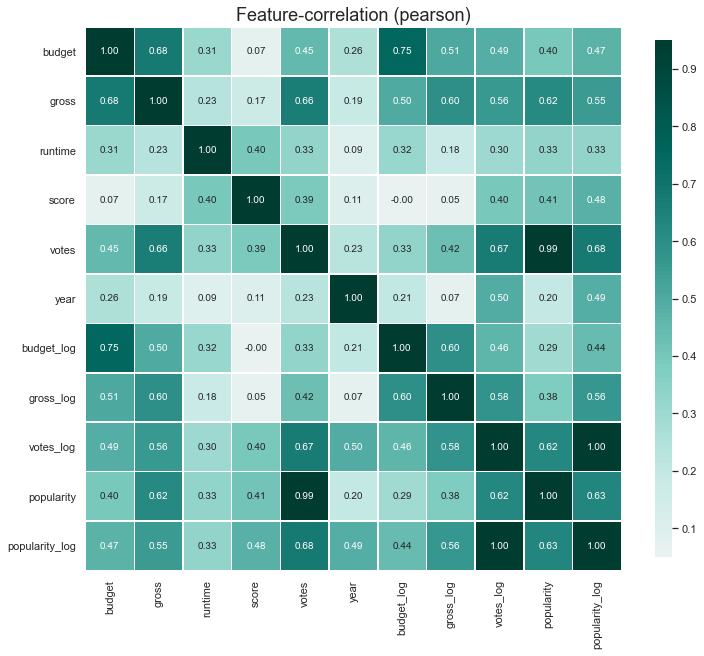

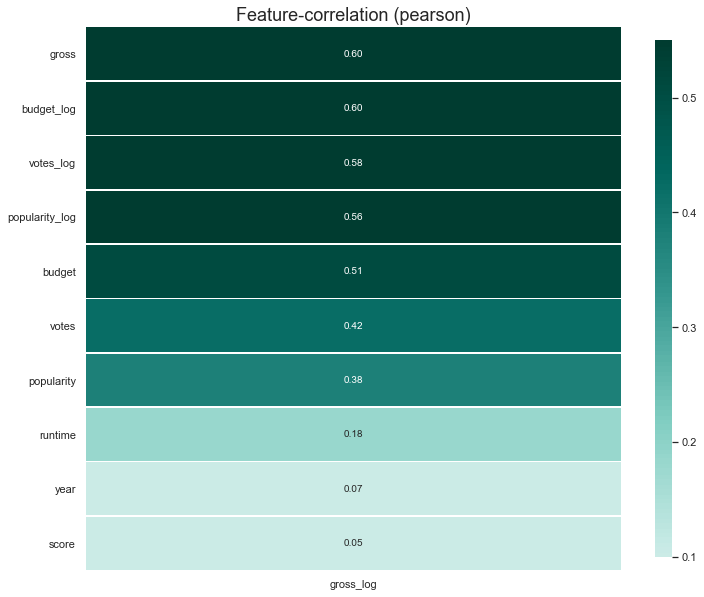

In [25]:
# new correlation between variables
klib.corr_plot(df, mask=False);
klib.corr_plot(df, target='gross_log');

## INSIGHTS

### QUESTION 1

**¿En qué género debería enfocarme?**

In [26]:
# number of observations by genre
df['genre'].value_counts()

Comedy       2080
Drama        1442
Action       1331
Crime         522
Adventure     392
Biography     359
Animation     277
Horror        277
Mystery        38
Fantasy        32
Thriller       18
Romance        15
Family         14
Sci-Fi         13
Musical         4
War             2
Western         2
Name: genre, dtype: int64

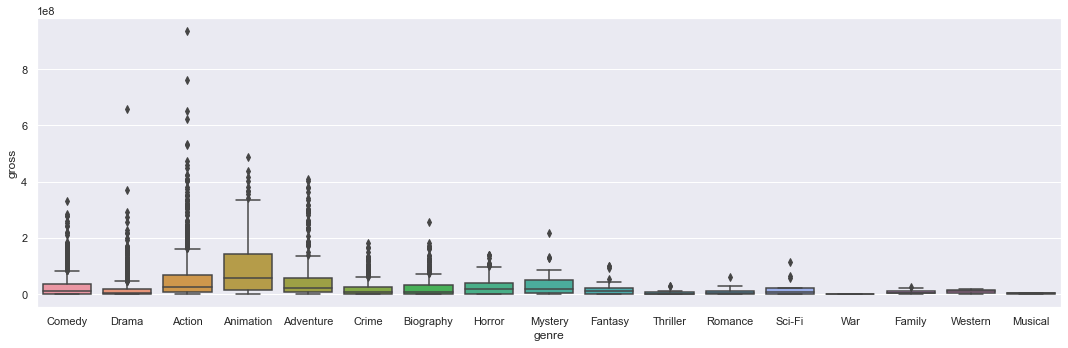

In [27]:
# boxplot by genre
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='genre', y='gross')
plt.tight_layout()  

In [28]:
# summary statistics by genre
df_genre_gross = df[['gross','genre']].groupby('genre').describe()
df_genre_gross.columns = df_genre_gross.columns.droplevel()
df_genre_gross.sort_values(by='50%', ascending=False, inplace=True) # sorting by median (more robust statistic than mean)
df_genre_gross

count          mean           std       min          25%  \
genre                                                                  
Animation   277.0  9.148810e+07  9.697904e+07    5274.0  13596911.00   
Action     1331.0  5.619281e+07  8.364603e+07     547.0   6914048.50   
Adventure   392.0  5.330381e+07  8.102622e+07   10230.0   5966297.25   
Mystery      38.0  3.631451e+07  4.760927e+07   68877.0   4900544.25   
Horror      277.0  2.569620e+07  2.895057e+07      70.0   1261000.00   
Fantasy      32.0  2.014541e+07  2.861964e+07    3478.0   1657111.25   
Comedy     2080.0  2.574203e+07  3.742141e+07     309.0   1687347.25   
Western       2.0  9.259547e+06  1.277099e+07  229094.0   4744320.50   
Biography   359.0  2.400425e+07  3.689086e+07    2670.0   1650605.50   
Crime       522.0  1.957440e+07  2.985027e+07     441.0    655195.00   
Sci-Fi       13.0  2.367705e+07  3.490682e+07   56129.0   1930001.00   
Family       14.0  8.436443e+06  8.047000e+06  781727.0   2138406.00   
Drama      1442.0  1.747805e+07  3.667710e+07    1800.0    505273.50   
Romance      15.0  9.717614e+06  1.677835e+07  121548.0    611919.50   
Musical       4.0  2.023748e+06  1.456929e+06   44757.0   1515009.75   
Thriller     18.0  5.533345e+06  9.302883e+06    1785.0    266995.50   
War           2.0  7.548875e+05  8.398781e+05  161004.0    457945.75   

                  50%           75%          max  
genre                                             
Animation  58867694.0  1.435286e+08  486295561.0  
Action     26873932.0  6.859523e+07  936662225.0  
Adventure  20839239.0  5.893822e+07  408010692.0  
Mystery    19370067.5  5.112538e+07  217536138.0  
Horror     17185632.0  3.956900e+07  140539099.0  
Fantasy    11034888.0  2.023836e+07  101071502.0  
Comedy     10912053.5  3.467921e+07  330252182.0  
Western     9259547.0  1.377477e+07   18290000.0  
Biography   8323085.0  3.060400e+07  255959475.0  
Crime       6477760.5  2.513003e+07  183405771.0  
Sci-Fi      5781885.0  2.233103e+07  115646235.0  
Family      5538349.0  1.144100e+07   26459681.0  
Drama       3539827.5  1.898366e+07  658672302.0  
Romance     2387928.0  1.206651e+07   62495645.0  
Musical     2275118.0  2.783856e+06    3500000.0  
Thriller     940699.5  7.492466e+06   29381956.0  
War          754887.5  1.051829e+06    1348771.0

In [29]:
# feature selection
# dropping features with high cardinality and budget because has high collinearity with other variables and
# has high percentatge of nans

feat_subset = ['gross', 'genre', 'rating', 'runtime', 'score', 'year', 'gross_log', 'budget_log',
               'votes_log', 'month', 'popularity_log']

df_sub = df[feat_subset]
df_sub.dropna(inplace=True)

<ipython-input-29-4e46751ad824>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.dropna(inplace=True)


In [30]:
df_sub.shape

(4638, 11)

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     106.3
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:52:04   Log-Likelihood:                -88647.
No. Observations:                4638   AIC:                         1.774e+05
Df Residuals:                    4599   BIC:                         1.776e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

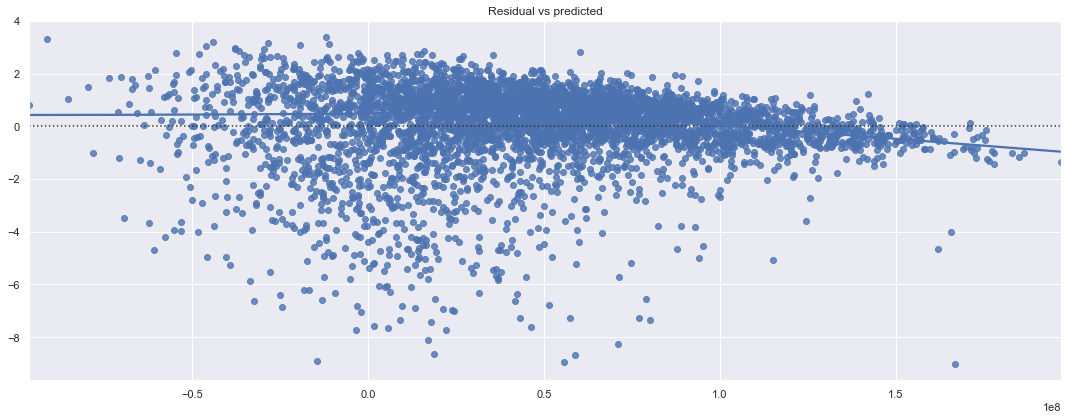

In [31]:
# choosing as baseline for genre Comedy, since its the genre with highest number of observations
# without budget (allows using more data to train)

equation = """
gross ~ runtime + score + year + votes_log + popularity_log + C(genre, Treatment(reference='Comedy')) + C(rating)+ C(month)
"""

mod = ols(equation, data=df_sub)
res = mod.fit()
print(res.summary())

residuals = df_sub['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = df_sub['gross']
y_pred = res.fittedvalues
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     30.43
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           1.91e-83
Time:                        20:52:07   Log-Likelihood:                -9749.7
No. Observations:                4638   AIC:                         1.953e+04
Df Residuals:                    4622   BIC:                         1.963e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

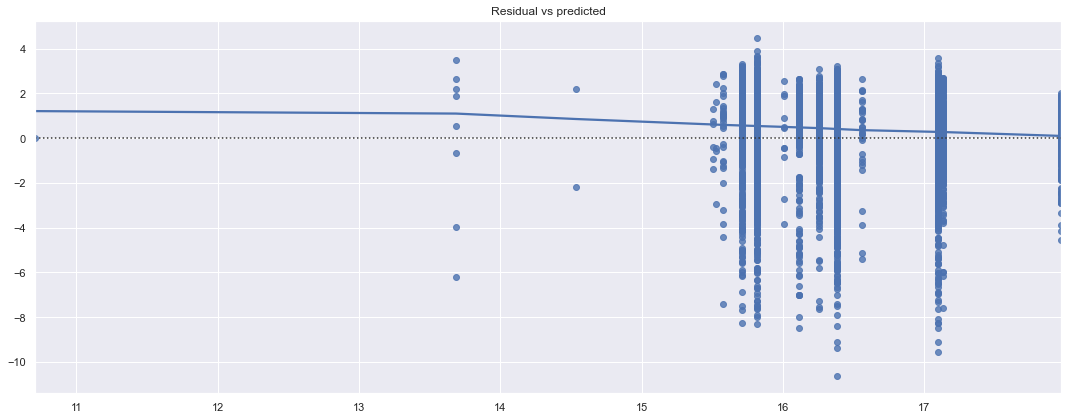

In [32]:
# log-transformed response with only genre 
equation = """
gross_log ~ C(genre, Treatment(reference='Comedy'))
"""

mod = ols(equation, data=df_sub)
res = mod.fit()
print(res.summary())

residuals = df_sub['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_sub['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

In [33]:
df_results = pd.DataFrame({'coeff':res.params.values,
              'pvalue':res.pvalues,
              '[0.025':res.conf_int(alpha=0.05)[0].values,
              '0.975]':res.conf_int(alpha=0.05)[1].values})

df_results = df_results.loc[df_results['pvalue']<= 0.05].sort_values(by='coeff', ascending=False)
coeff_genre = df_results['coeff']

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     161.0
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:52:07   Log-Likelihood:                -7971.5
No. Observations:                4638   AIC:                         1.602e+04
Df Residuals:                    4598   BIC:                         1.628e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

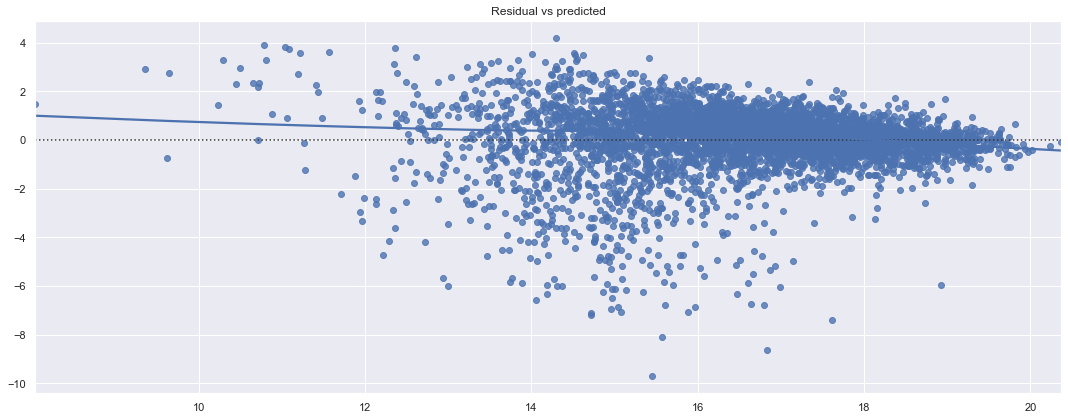

In [34]:
# log-transformed response
equation = """
gross_log ~ runtime + score + year + budget_log + votes_log + popularity_log
            + C(genre, Treatment(reference='Comedy')) + C(rating)+ C(month)
"""

mod = ols(equation, data=df_sub)
res = mod.fit()
print(res.summary())

residuals = df_sub['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_sub['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     88.76
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:52:10   Log-Likelihood:                -8745.1
No. Observations:                4638   AIC:                         1.756e+04
Df Residuals:                    4601   BIC:                         1.780e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

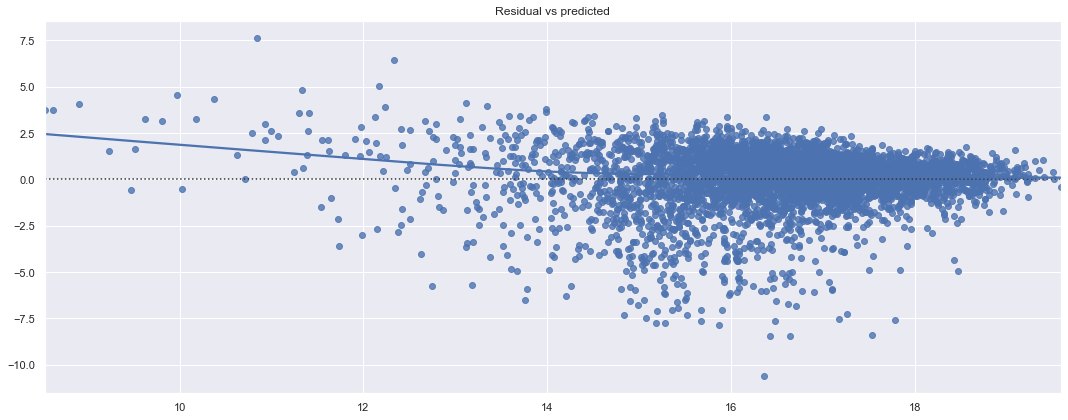

In [35]:
# log-transformed with variables that the producer can control (no votes, no note)
equation = """
gross_log ~ runtime + year + budget_log + C(genre, Treatment(reference='Comedy')) + C(rating)+ C(month)
"""

mod = ols(equation, data=df_sub)
res = mod.fit()
print(res.summary())

residuals = df_sub['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_sub['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

In [36]:
df_results = pd.DataFrame({'coeff':res.params.values,
              'pvalue':res.pvalues,
              '[0.025':res.conf_int(alpha=0.05)[0].values,
              '0.975]':res.conf_int(alpha=0.05)[1].values})

df_results = df_results.loc[df_results['pvalue']<= 0.05]
coeff_genre_full = df_results['coeff']

In [37]:
# model without budget -> genre with highest coeff is Animation
# betta=0.6170      conf_int=[ 0.379       0.855]

print(np.exp(0.6170))
print(np.exp(0.379))
print(np.exp(0.855))

1.8533596145380853
1.4608230357434318
2.351374380574902


In [38]:
# variables producer -> genre with highest coeff is Horror
# betta=0.4551           conf_int=[0.225       0.685]

print(np.exp(0.4551))
print(np.exp(0.225))
print(np.exp(0.685))

1.576331008253424
1.2523227161918644
1.98377183553716


SUMMARY

- We have few data about Musical, War and Western genres, so the inference involving that genres can be not accurate
- Log-transforming response variable we get higher coefficient of determination.
- There is multicolliniarity in the data, however it exist between numerical variables, so it is not affecting genre variable.
- The genre with the highest median gross is animation (using median instead of mean since it is more robust against extreme values).
- Switching from Comedy genre (the most produced) to Animation genre, we expect to see about 85% increase in the geometric mean of gross value, when other variables are held at some fixed value and we do not care about budget.
- We are 95% confident that switching from Comedy genre to Animation genre increase the gross between 46% and 135%, , when other variables are held at some fixed value and we do not care about budget (if we were to collect new data generated from the same distribution then in 19 out of every 20 experiments we'd get a coefficient interval including the real value of the coefficient).
- There is no significant evidence that another gender increases the value of the gross.


With variables that the producer can control:
- Switching from Comedy genre (the most produced) to Horror genre, we expect to see about 58% increase in the geometric mean of gross value, when other variables are held at some fixed value.
- We are 95% confident that switching from Comedy genre to Animation genre increase the gross between 25% and 98%, when other variables are held at some fixed value.

### QUESTION 2

**¿Qué tan importante es producir una buena película (rating IMDB alto) para obtener muchos ingresos?**

We investigate if there is multicollinearity in the explanatory variables:

In [39]:
feat_sel = ['runtime','score','year','budget_log','votes_log','popularity_log']

X = df.select_dtypes(exclude='object')[feat_sel].dropna()
X.columns

Index(['runtime', 'score', 'year', 'budget_log', 'votes_log',
       'popularity_log'],
      dtype='object')

In [40]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor        features
0      52.437023         runtime
1    1666.158659           score
2     773.345632            year
3     269.879230      budget_log
4  129841.880364       votes_log
5  181422.105274  popularity_log

In [41]:
X = X.drop('popularity_log',axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor    features
0   50.702334     runtime
1   67.562330       score
2  212.177433        year
3  254.097754  budget_log
4  103.192954   votes_log

In [42]:
X = X.drop('budget_log',axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor   features
0   45.374158    runtime
1   58.231764      score
2   77.096642       year
3   77.654682  votes_log

In [43]:
X = X.drop('votes_log',axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor features
0   44.386740  runtime
1   49.129147    score
2   54.272422     year

In [44]:
X = X.drop('year',axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor features
0   33.234168  runtime
1   33.234168    score

We observe multicollinearity between score and all the others explanatory variables.

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     83.42
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           9.68e-20
Time:                        20:52:13   Log-Likelihood:                -9926.8
No. Observations:                4638   AIC:                         1.986e+04
Df Residuals:                    4636   BIC:                         1.987e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.7595      0.192     76.728      0.0

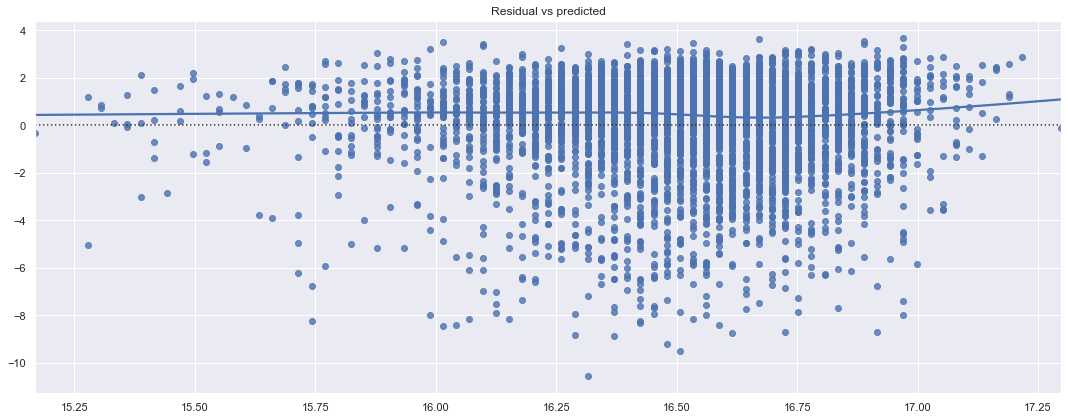

In [45]:
# only score variable
equation = """
gross_log ~ score
"""

mod = ols(equation, data=df_sub)
res = mod.fit()
print(res.summary())

residuals = df_sub['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

Scaling the data to reduce estructural collinearity:

In [46]:
feat_sel = ['runtime','score','year','budget_log','votes_log','popularity_log']

X = df.select_dtypes(exclude='object')[feat_sel].dropna()
X.columns

Index(['runtime', 'score', 'year', 'budget_log', 'votes_log',
       'popularity_log'],
      dtype='object')

In [47]:
scaler= StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feat_sel)

In [48]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
vif["features"] = X_scaled.columns
vif

VIF Factor        features
0     1.432214         runtime
1    41.232656           score
2     1.225259            year
3     1.645454      budget_log
4  2253.410522       votes_log
5  2587.606943  popularity_log

In [49]:
X_scaled = X_scaled.drop('popularity_log', axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
vif["features"] = X_scaled.columns
vif

VIF Factor    features
0    1.385332     runtime
1    1.703472       score
2    1.208732        year
3    1.548515  budget_log
4    2.069782   votes_log

We have solved the problem of mulitcollinearity centering the variables.

In [50]:
# adding categorical variables and response to the scaled variables
X_add = df.dropna() # dropping rows with missing values in budget
X_add = X_add[['genre','rating','month','gross_log']].reset_index(drop=True)

# full dataset
df_full = pd.concat([X_scaled, X_add], axis=1)
df_full.head()

runtime     score      year  budget_log  votes_log   genre rating month  \
0  0.577358  0.142126 -1.830781    0.090655   0.171859  Comedy      R     6   
1 -0.476976 -0.352456 -0.530631    0.854653   0.093505  Action      R    10   
2  0.244410  0.241042  1.360497    0.618476   1.337355  Comedy      R    12   
3  1.742675 -1.044871 -0.530631    1.443425   0.974126  Action  PG-13     5   
4 -0.421485 -0.847039 -0.412436    0.326833  -0.904495   Drama      R     1   

   gross_log  
0  17.970739  
1  16.494330  
2  15.624647  
3  18.730474  
4  16.301864

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     160.0
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:52:13   Log-Likelihood:                -8014.9
No. Observations:                4638   AIC:                         1.611e+04
Df Residuals:                    4599   BIC:                         1.636e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

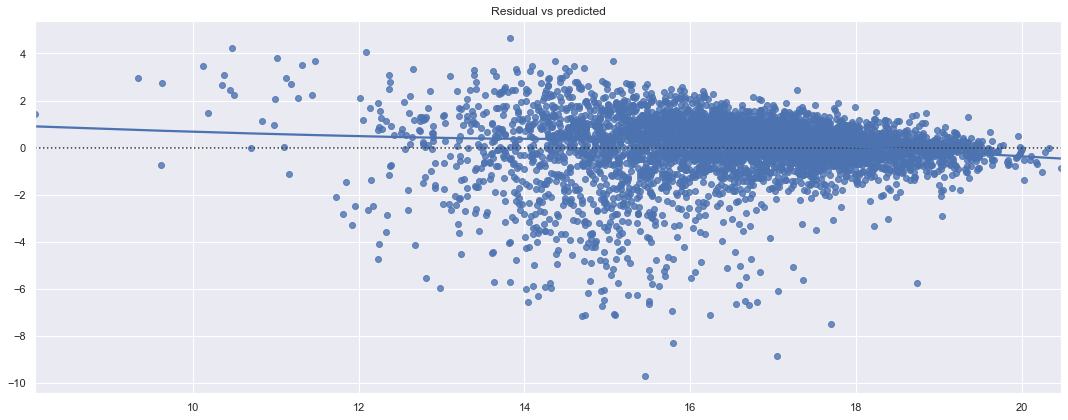

In [51]:
# no collinearity
equation = """
gross_log ~ runtime + score + year + budget_log + votes_log + C(genre, Treatment(reference='Comedy')) + C(rating)+ C(month)
"""

mod = ols(equation, data=df_full)
res = mod.fit()
print(res.summary())

residuals = df_full['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_full['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     164.3
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:52:16   Log-Likelihood:                -8014.9
No. Observations:                4638   AIC:                         1.611e+04
Df Residuals:                    4600   BIC:                         1.635e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

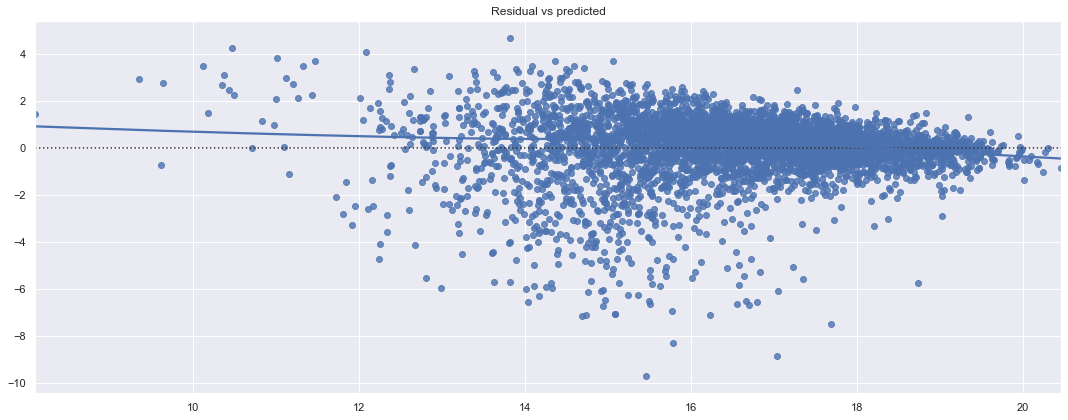

In [52]:
# no collinearity without runtime
equation = """
gross_log ~ score + year + budget_log + votes_log + C(genre, Treatment(reference='Comedy')) + C(rating)+ C(month)
"""

mod = ols(equation, data=df_full)
res = mod.fit()
print(res.summary())

residuals = df_full['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_full['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

In [53]:
# model wit only score as explanatory variable
# betta=0.2730      conf_int=[0.214       0.332]

print(np.exp(0.2730))
print(np.exp(0.214))
print(np.exp(0.332))

1.3139002448247392
1.2386226547934522
1.3937528485125166


In [54]:
# model wit all variables except runtime since it is not statistical significant.
# betta=-0.1392      conf_int=[-0.192      -0.086]

# standarized betas back to original
sd_score = scaler.scale_[1] # standard deviation of score variable

print(1 - np.exp(-0.1392/sd_score))
print(1 - np.exp(-0.192/sd_score))
print(1 - np.exp(-0.086/sd_score))

0.1286326771059917
0.17297432516390354
0.0815502886821371


In [55]:
# budget_log
# betta = 0.6603   conf_int= [0.608       0.713]

sd_budget_log = scaler.scale_[3]
print(1.10**(0.6603/sd_budget_log))
print(1.10**(0.608/sd_budget_log))
print(1.10**(0.713/sd_budget_log))

1.0490895368368747
1.0451149676314915
1.053109793549089


In [56]:
# votes_log
# betta = 1.1275   conf_int= [1.067       1.188]

sd_votes_log = scaler.scale_[4]
print(1.10**(1.1275/sd_votes_log))
print(1.10**(1.067/sd_votes_log))
print(1.10**(1.188/sd_votes_log))

1.0792025521737776
1.0747976473519192
1.0836255098696235


SUMMARY

* When we do not care about other variables, for a unit increase in score, we expect to see about a 31% increase in gross. And we are 95% confident that a unit increase in score, increases the gross between 24% to 39%.
* Considering all the variables, for a unit increase in score, we expect to see about a 13% **decrease** in gross. And we are 95% confident that a unit increase in score, **decrease** the gross between 8% to 17%. (holding all the other variables fixed at any value.)
* Other variables as the budget of the film or the popularity (number of votes) are really important and statistical significant. For instance:
    * We expect a 5% increase in gross when budget increase by 10%
    * We expect a 8% increase in gross when votes (popularity) increase by 10%

#### MULTICOLLINEARITY PROBLEM

The need to reduce multicollinearity depends on its severity and your primary goal for your regression model. Keep the following three points in mind:

1. The severity of the problems increases with the degree of the multicollinearity. Therefore, if you have only moderate multicollinearity, you may not need to resolve it.
2. Multicollinearity affects only the specific independent variables that are correlated. Therefore, if multicollinearity is not present for the independent variables that you are particularly interested in, you may not need to resolve it. Suppose your model contains the experimental variables of interest and some control variables. If high multicollinearity exists for the control variables but not the experimental variables, then you can interpret the experimental variables without problems.
3. Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics. If your primary goal is to make predictions, and you don’t need to understand the role of each independent variable, you don’t need to reduce severe multicollinearity.

Source : [https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/#:~:text=Multicollinearity%20affects%20only%20the%20specific%20independent%20variables%20that%20are%20correlated.&text=Multicollinearity%20affects%20the%20coefficients%20and,goodness%2Dof%2Dfit%20statistics.]

Scaling the variables we avoid the problem of large number condition, so it was not because of the multicollinearity between explanatory variables rather for the scaling:

### QUESTION 3

**¿Es mejor producir una película para todos los públicos? ¿O una dirigida sólo al público adulto?**

In [57]:
# unique film ratings
df['rating'].unique()

array(['R', 'PG-13', 'PG', 'G', 'Not specified', 'NOT RATED', 'NC-17',
       'UNRATED', 'B', 'TV-14', 'B15', 'TV-MA', 'TV-PG'], dtype=object)

In [58]:
df['rating'].value_counts()

R                3391
PG-13            1995
PG                951
NOT RATED         174
G                 146
UNRATED            71
Not specified      63
NC-17              22
TV-PG               1
TV-MA               1
TV-14               1
B                   1
B15                 1
Name: rating, dtype: int64

Adults: NC-17 and R, TV-MA

Definition of rating in EE.UU:

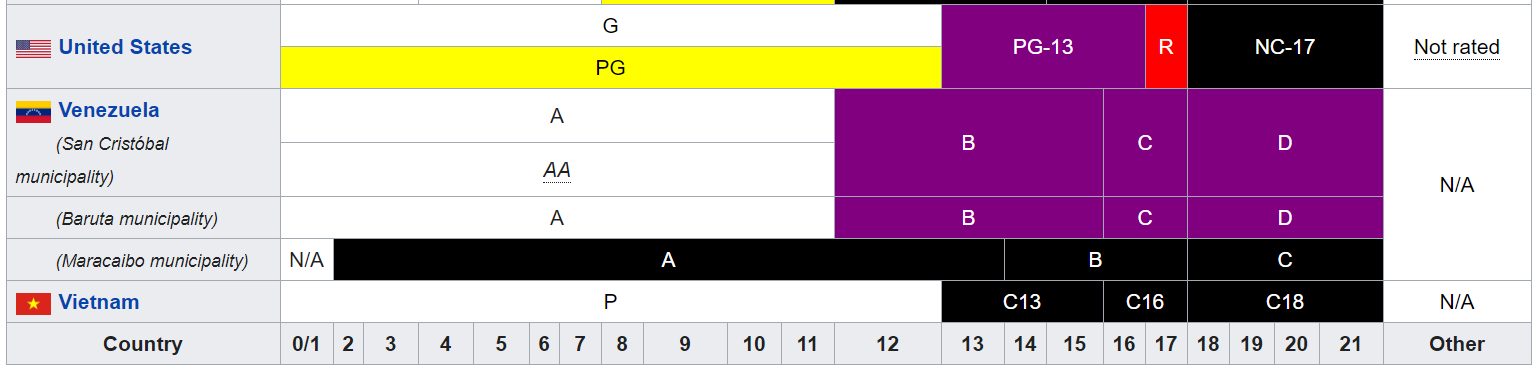

In [59]:
rating_adults = ['NC-17','R','TV-MA'] 
rating_allpublic = ['G','PG','TV-PG']

def target_audience(item):
    if item in rating_allpublic:
        return 'all_publics'
    elif item in rating_adults:
        return 'only_adults'
    else:
        return 'other'

df['audience'] = df['rating'].apply(target_audience)
print(df.shape)

(6818, 22)


In [60]:
# df_audience = df.loc[df['audience']!='other']
df_audience = df.copy()
df_audience.dropna(inplace=True)
print(df_audience.shape)
df_audience.head()

(4638, 22)


budget                       company country            director  \
239    22000000.0                  Warner Bros.     USA       George Miller   
2687   60000000.0                  Warner Bros.      UK  Paul W.S. Anderson   
6198   44000000.0             Columbia Pictures     USA       Evan Goldberg   
2684  130000000.0  Centropolis Film Productions     USA     Roland Emmerich   
3034   30000000.0          Amblin Entertainment     USA         Neil Jordan   

       genre        gross                     name rating   released  runtime  \
239   Comedy   63766510.0  The Witches of Eastwick      R 1987-06-12      118   
2687  Action   14567883.0                  Soldier      R 1998-10-23       99   
6198  Comedy    6105175.0            The Interview      R 2014-12-24      112   
2684  Action  136314294.0                 Godzilla  PG-13 1998-05-20      139   
3034   Drama   12017369.0                In Dreams      R 1999-01-15      100   

      ...   votes              writer  year budget_log  gross_log  votes_log  \
239   ...   51642         John Updike  1987  16.906553  17.970739  10.852091   
2687  ...   46241  David Webb Peoples  1998  17.909855  16.494330  10.741622   
6198  ...  267070        Dan Sterling  2014  17.599700  15.624647  12.495266   
2684  ...  160038         Dean Devlin  1998  18.683045  18.730474  11.983167   
3034  ...   11323           Bari Wood  1999  17.216708  16.301864   9.334591   

      month  popularity popularity_log     audience  
239       6    335673.0      12.723893  only_adults  
2687     10    277446.0      12.533382  only_adults  
6198     12   1762662.0      14.382336  only_adults  
2684      5    848201.4      13.650873        other  
3034      1     62276.5      11.039339  only_adults  

[5 rows x 22 columns]

In [61]:
df_audience['audience'].value_counts()

only_adults    2256
other          1623
all_publics     759
Name: audience, dtype: int64

In [62]:
# only audience variable
equation = """
gross_log ~ C(audience, Treatment(reference='only_adults'))
"""

mod = ols(equation, data=df_audience)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     215.9
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           2.33e-90
Time:                        20:52:19   Log-Likelihood:                -9761.6
No. Observations:                4638   AIC:                         1.953e+04
Df Residuals:                    4635   BIC:                         1.955e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     97.11
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:52:19   Log-Likelihood:                -8801.8
No. Observations:                4638   AIC:                         1.767e+04
Df Residuals:                    4606   BIC:                         1.787e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

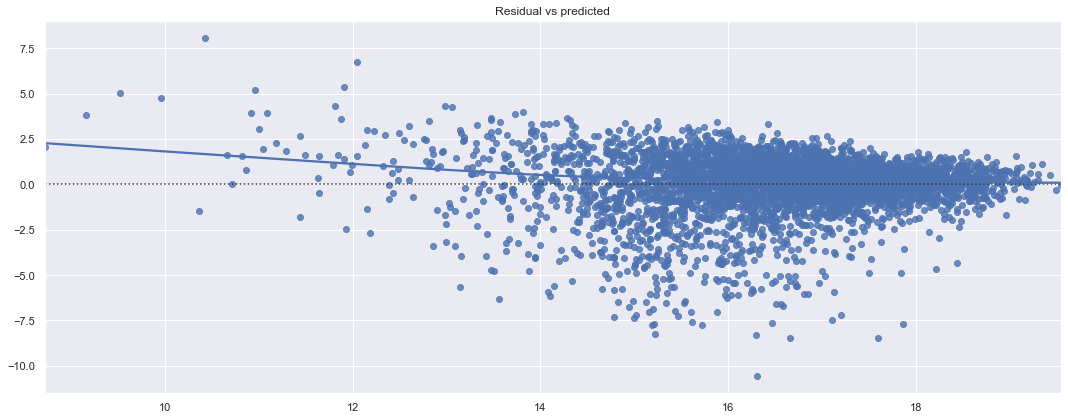

In [63]:
# with other variables
equation = """
gross_log ~ runtime + year + budget_log + C(audience)+ C(month) + C(genre, Treatment(reference='Comedy'))
"""
mod = ols(equation, data=df_audience)
res = mod.fit()
print(res.summary())

residuals = df_audience['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_audience['gross_log'].dropna())
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     148.3
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:52:22   Log-Likelihood:                -8817.3
No. Observations:                4638   AIC:                         1.768e+04
Df Residuals:                    4617   BIC:                         1.781e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

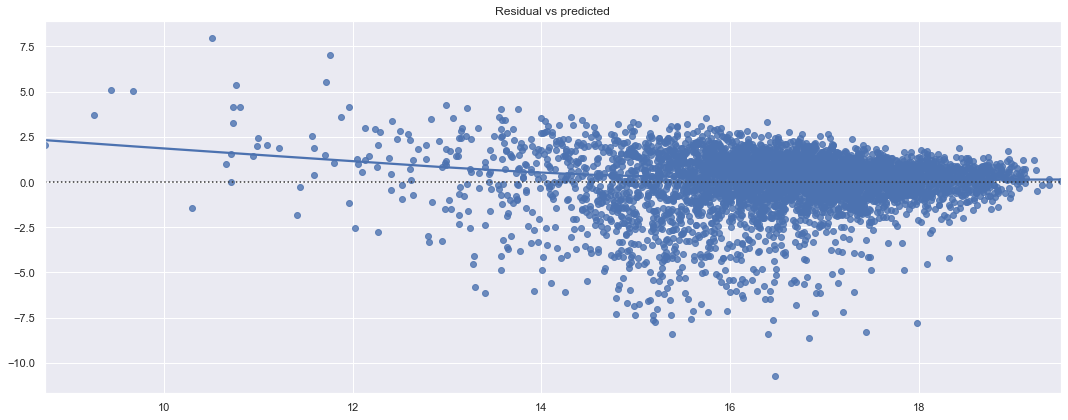

In [64]:
# without month (not significant)
equation = """
gross_log ~ runtime + year + budget_log + C(audience) + C(genre, Treatment(reference='Comedy'))
"""
mod = ols(equation, data=df_audience)
res = mod.fit()
print(res.summary())

residuals = df_audience['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_audience['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

In [65]:
feat = ['runtime', 'year', 'budget_log']
X = df_audience[feat]

In [66]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor    features
0   40.776766     runtime
1  171.668282        year
2  186.210535  budget_log

In [67]:
X = X.drop('budget_log', axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor features
0   36.713415  runtime
1   36.713415     year

In [68]:
X = df_audience[feat]

scaler= StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feat)

In [69]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
vif["features"] = X_scaled.columns
vif

VIF Factor    features
0    1.113497     runtime
1    1.044646        year
2    1.160123  budget_log

In [70]:
# adding categorical variables and response to the scaled variables
X_add = df_audience.dropna() # dropping rows with missing values in budget
X_add = X_add[['genre','rating','month','gross_log','audience']].reset_index(drop=True)

# full dataset
df_full = pd.concat([X_scaled, X_add], axis=1)
df_full.head()

runtime      year  budget_log   genre rating month  gross_log     audience
0  0.577358 -1.830781    0.090655  Comedy      R     6  17.970739  only_adults
1 -0.476976 -0.530631    0.854653  Action      R    10  16.494330  only_adults
2  0.244410  1.360497    0.618476  Comedy      R    12  15.624647  only_adults
3  1.742675 -0.530631    1.443425  Action  PG-13     5  18.730474        other
4 -0.421485 -0.412436    0.326833   Drama      R     1  16.301864  only_adults

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     148.3
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:52:25   Log-Likelihood:                -8817.3
No. Observations:                4638   AIC:                         1.768e+04
Df Residuals:                    4617   BIC:                         1.781e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

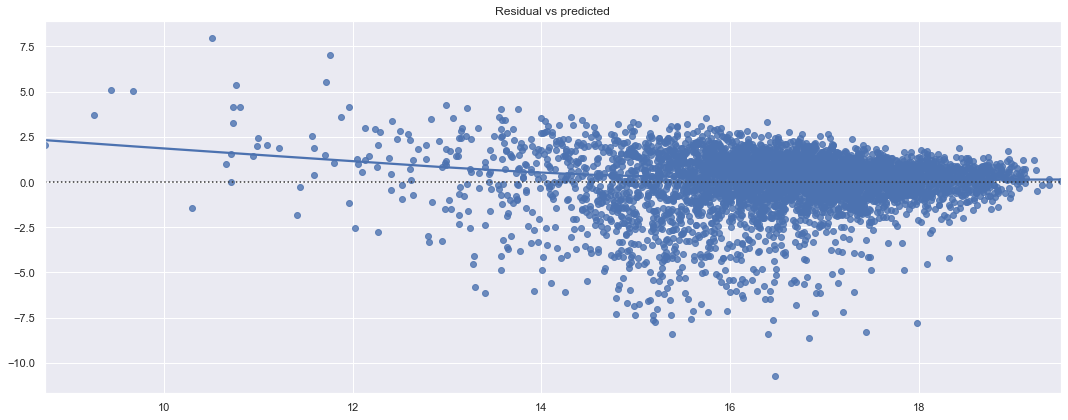

In [71]:
# without month (not significant) and no collinearity
equation = """
gross_log ~ runtime + year + budget_log + C(audience, Treatment(reference='only_adults')) + C(genre, Treatment(reference='Comedy'))
"""
mod = ols(equation, data=df_full)
res = mod.fit()
print(res.summary())

residuals = df_full['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_full['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

In [72]:
# model with audience
# betta=1.4343      conf_int=[1.271       1.598]

print(np.exp(1.4343))
print(np.exp(1.271))
print(np.exp(1.598))

4.196706285954761
3.5644151959377806
4.943136259010431


In [73]:
# model wit all variables
# betta=0.5864      conf_int=[0.422       0.751]

print(np.exp(0.5864))
print(np.exp(0.422))
print(np.exp(0.751))

1.7975057329321584
1.5250085246832794
2.119118075482217


SUMMARY

* When we do not care about other variables, switching from a film only for adults to a film for all publics, we expect to see about a 319% increase in gross. And we are 95% confident that the change, increases the gross between 256% to 394%.

* Considering all the variables, switching from a film only for adults to a film for all publics, we expect to see about a 80% increase in gross. And we are 95% confident that the change, increases the gross between 52% to 112%.

### QUESTION 4

**¿Hay algún actor que garantice el éxito de la película?**

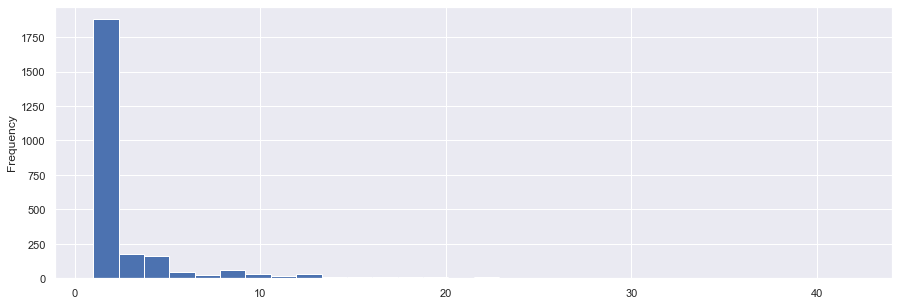

In [74]:
df_stars = df[['gross','star']].groupby('star').agg(['mean','median','sum','count'])
df_stars = df_stars.droplevel(0, axis=1)
# distribution of appearances
df_stars['count'].plot.hist(bins=30, figsize=(15,5));

In [75]:
N = 5 # minimum number of appearances to take star into account

df_stars = df_stars.loc[df_stars['count']>5]
df_stars.sort_values(by='median', ascending=False).head()

mean       median           sum  count
star                                                             
Daniel Radcliffe   1.753354e+08  255673604.5  2.454696e+09     14
Jennifer Lawrence  2.057685e+08  190869300.5  1.646148e+09      8
Kristen Stewart    1.539129e+08  173398897.5  1.539129e+09     10
Mike Myers         1.709427e+08  163868718.0  2.051312e+09     12
Will Smith         1.328879e+08  126207062.5  2.657757e+09     20

In [76]:
dfviz_stars = df_stars.sort_values(by='count', ascending=False)

In [77]:
# filtering films with stars with more than N appearances
l_stars = list(df_stars.index)
df_sub = df.loc[df['star'].isin(l_stars)]
df_sub.dropna(inplace=True)
print(df_sub.shape)

(2708, 22)


<ipython-input-77-d70527237d34>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.dropna(inplace=True)


In [78]:
# removing estructural multicollinearity
feat = ['runtime', 'year', 'budget_log']
X = df_sub[feat]

scaler= StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feat)

# adding categorical variables and response to the scaled variables
X_add = df_sub
X_add = X_add[['genre','month','gross_log','audience','star']].reset_index(drop=True)

# full dataset
df_full = pd.concat([X_scaled, X_add], axis=1)
print(df_full.shape)
df_full.head()

(2708, 8)


runtime      year  budget_log   genre month  gross_log     audience  \
0  0.355488 -1.893527   -0.264705  Comedy     6  17.970739  only_adults   
1 -0.657728 -0.547650    0.702801  Action    10  16.494330  only_adults   
2  0.035525  1.409991    0.403712  Comedy    12  15.624647  only_adults   
3  1.475358 -0.547650    1.448404  Action     5  18.730474        other   
4  0.675451  0.553523    1.448404  Action    12  19.208975  all_publics   

                star  
0     Jack Nicholson  
1       Kurt Russell  
2       James Franco  
3  Matthew Broderick  
4       Nicolas Cage

MAE:31848189.052772734
MAPE:690.208131154399


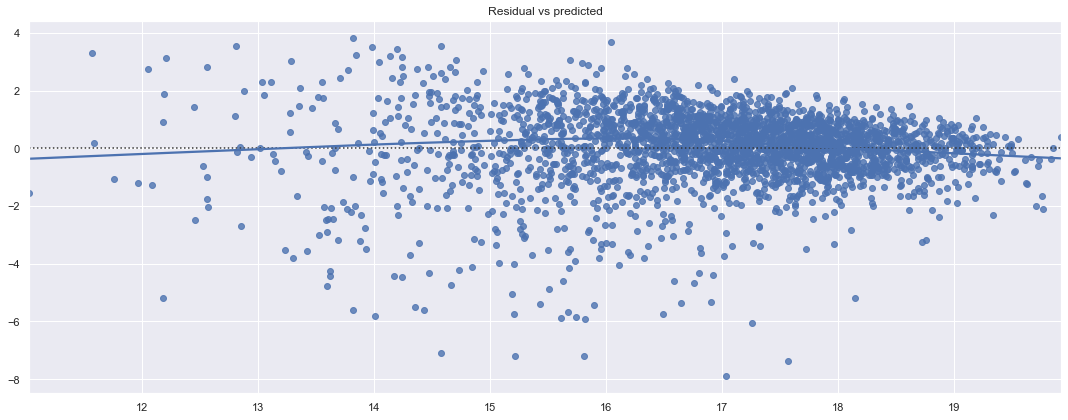

In [79]:
# considering all variables
equation = """
gross_log ~ runtime + year + budget_log + C(audience, Treatment(reference='only_adults')) +
                C(genre, Treatment(reference='Comedy')) + C(star, Treatment(reference='Nicolas Cage'))
"""
mod = ols(equation, data=df_full)
res = mod.fit()
# print(res.summary())

residuals = df_full['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_full['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

In [80]:
df_results_fullstars = pd.DataFrame({'coeff':res.params.values,
              'pvalue':res.pvalues,
              '[0.025':res.conf_int(alpha=0.05)[0].values,
              '0.975]':res.conf_int(alpha=0.05)[1].values})

df_results_fullstars = df_results_fullstars.loc[df_results_fullstars['pvalue']<= 0.05].sort_values(by='coeff', ascending=False)
df_results_fullstars

coeff    pvalue  \
Intercept                                           16.315298  0.000000   
C(star, Treatment(reference='Nicolas Cage'))[T....   2.148735  0.000057   
C(star, Treatment(reference='Nicolas Cage'))[T....   1.963858  0.001138   
C(star, Treatment(reference='Nicolas Cage'))[T....   1.800577  0.000216   
C(star, Treatment(reference='Nicolas Cage'))[T....   1.797024  0.000776   
...                                                       ...       ...   
C(star, Treatment(reference='Nicolas Cage'))[T....  -2.404770  0.000226   
C(star, Treatment(reference='Nicolas Cage'))[T....  -2.421800  0.000058   
C(star, Treatment(reference='Nicolas Cage'))[T....  -2.459217  0.002671   
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.266380  0.001191   
C(star, Treatment(reference='Nicolas Cage'))[T....  -4.087705  0.000040   

                                                       [0.025     0.975]  
Intercept                                           15.859393  16.771202  
C(star, Treatment(reference='Nicolas Cage'))[T....   1.103198   3.194271  
C(star, Treatment(reference='Nicolas Cage'))[T....   0.781798   3.145918  
C(star, Treatment(reference='Nicolas Cage'))[T....   0.847569   2.753586  
C(star, Treatment(reference='Nicolas Cage'))[T....   0.749982   2.844066  
...                                                       ...        ...  
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.681426  -1.128113  
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.600395  -1.243205  
C(star, Treatment(reference='Nicolas Cage'))[T....  -4.063253  -0.855181  
C(star, Treatment(reference='Nicolas Cage'))[T....  -5.240237  -1.292522  
C(star, Treatment(reference='Nicolas Cage'))[T....  -6.035674  -2.139736  

[65 rows x 4 columns]

MAE:38585791.76780679
MAPE:1660.4174969650646


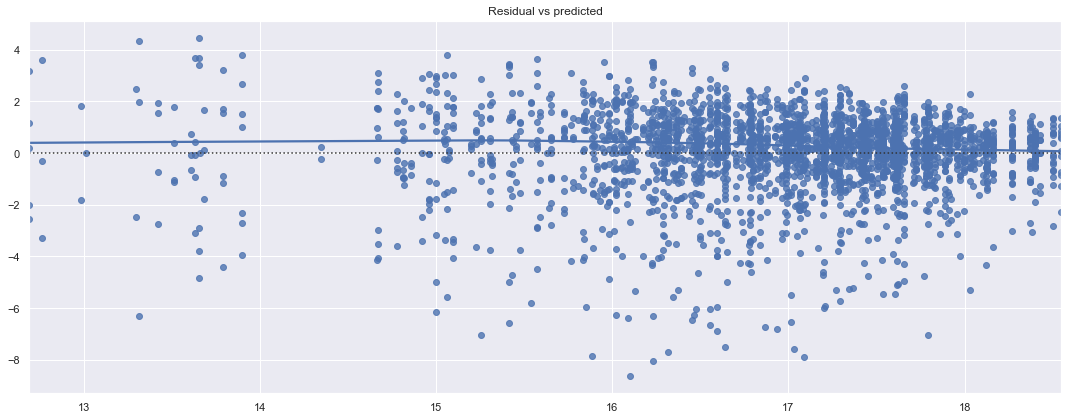

In [81]:
# considering only star
equation = """
gross_log ~ C(star, Treatment(reference='Nicolas Cage'))
"""
mod = ols(equation, data=df_full)
res = mod.fit()
# print(res.summary())

residuals = df_full['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_full['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

In [82]:
df_results_stars = pd.DataFrame({'coeff':res.params.values,
              'pvalue':res.pvalues,
              '[0.025':res.conf_int(alpha=0.05)[0].values,
              '0.975]':res.conf_int(alpha=0.05)[1].values})

df_results_stars = df_results_stars.loc[df_results_stars['pvalue']<= 0.05].sort_values(by='coeff', ascending=False)
df_results_stars

coeff        pvalue  \
Intercept                                           16.595536  0.000000e+00   
C(star, Treatment(reference='Nicolas Cage'))[T....   1.953869  4.172293e-04   
C(star, Treatment(reference='Nicolas Cage'))[T....   1.908595  2.069420e-03   
C(star, Treatment(reference='Nicolas Cage'))[T....   1.906584  3.362429e-03   
C(star, Treatment(reference='Nicolas Cage'))[T....   1.834250  4.780980e-03   
...                                                       ...           ...   
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.296838  6.542533e-03   
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.583546  3.423462e-02   
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.610802  2.903423e-03   
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.832761  1.326750e-04   
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.905385  9.397940e-07   

                                                       [0.025     0.975]  
Intercept                                           16.064385  17.126688  
C(star, Treatment(reference='Nicolas Cage'))[T....   0.869661   3.038077  
C(star, Treatment(reference='Nicolas Cage'))[T....   0.694799   3.122392  
C(star, Treatment(reference='Nicolas Cage'))[T....   0.632928   3.180240  
C(star, Treatment(reference='Nicolas Cage'))[T....   0.560594   3.107906  
...                                                       ...        ...  
C(star, Treatment(reference='Nicolas Cage'))[T....  -5.672218  -0.921458  
C(star, Treatment(reference='Nicolas Cage'))[T....  -6.900584  -0.266508  
C(star, Treatment(reference='Nicolas Cage'))[T....  -5.986182  -1.235422  
C(star, Treatment(reference='Nicolas Cage'))[T....  -5.796345  -1.869177  
C(star, Treatment(reference='Nicolas Cage'))[T....  -5.463026  -2.347744  

[68 rows x 4 columns]

### QUESTION 5

**¿Hay algún director que garantice el éxito de la película?**

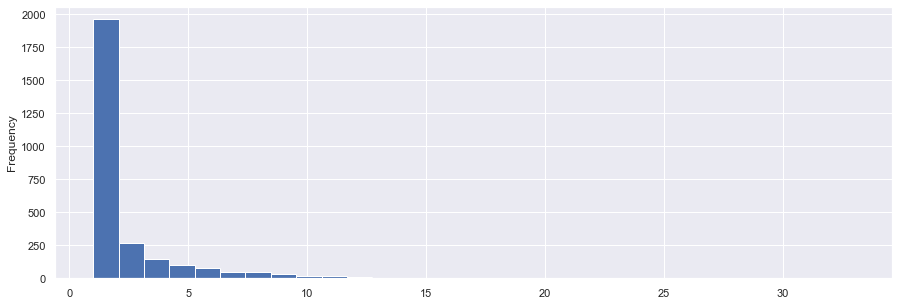

In [83]:
df_director = df[['gross','director']].groupby('director').agg(['mean','median','sum','count'])
df_director = df_director.droplevel(0, axis=1)
df_director['count'].plot.hist(bins=30, figsize=(15,5));

In [84]:
N = 5 # minimum numbe of films to take director into consideration
df_director = df_director.loc[df_director['count']>5]
df_director.sort_values(by='median', ascending=False).head()

mean       median           sum  count
director                                                         
David Yates        2.719398e+08  293994021.5  1.631639e+09      6
Francis Lawrence   2.391000e+08  269055059.0  1.434600e+09      6
Peter Jackson      1.940347e+08  255119788.0  2.134382e+09     11
Christopher Nolan  2.018317e+08  188020017.0  1.816485e+09      9
James Cameron      3.183212e+08  175562880.5  1.909927e+09      6

In [85]:
# filtering directors with more than N films
l_director = list(df_director.index)
df_sub = df.loc[df['director'].isin(l_director)]
df_sub.dropna(inplace=True)
print(df_sub.shape)

(1979, 22)


<ipython-input-85-cd8e96f69427>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.dropna(inplace=True)


In [86]:
# removing multicollinearity
feat = ['runtime', 'year', 'budget_log']
X = df_sub[feat]

scaler= StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feat)

# adding categorical variables and response to the scaled variables
X_add = df_sub
X_add = X_add[['genre','month','gross_log','audience','director']].reset_index(drop=True)

# full dataset
df_full = pd.concat([X_scaled, X_add], axis=1)
print(df_full.shape)
df_full.head()

(1979, 8)


runtime      year  budget_log   genre month  gross_log     audience  \
0  0.262778 -1.760007   -0.223435  Comedy     6  17.970739  only_adults   
1 -0.735879 -0.415482    0.642641  Action    10  16.494330  only_adults   
2  1.366557 -0.415482    1.310079  Action     5  18.730474        other   
3 -0.683319 -0.293252    0.044299   Drama     1  16.301864  only_adults   
4  0.578144  0.684584    1.310079  Action    12  19.208975  all_publics   

             director  
0       George Miller  
1  Paul W.S. Anderson  
2     Roland Emmerich  
3         Neil Jordan  
4      Jon Turteltaub

MAE:36109605.99011095
MAPE:1278.6065070989716


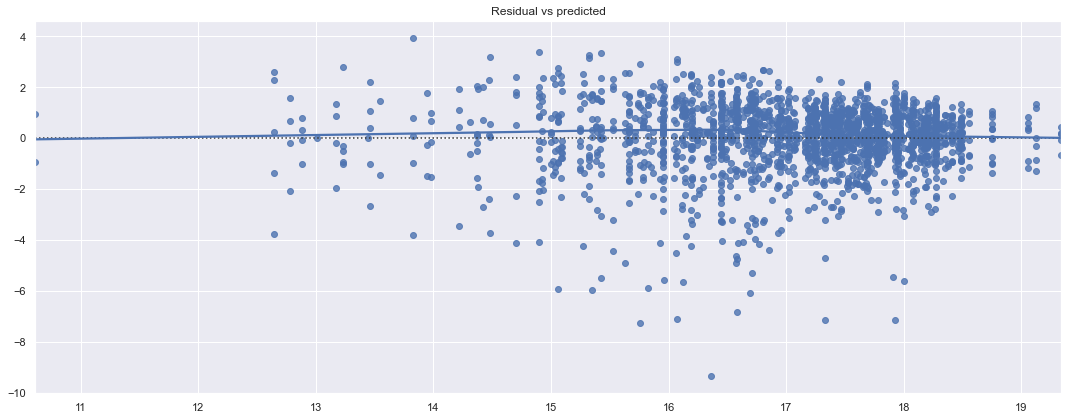

In [87]:
# considering only director
equation = """
gross_log ~ C(director, Treatment(reference='Woody Allen'))
"""
mod = ols(equation, data=df_full)
res = mod.fit()
# print(res.summary())

residuals = df_full['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_full['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

In [88]:
df_results = pd.DataFrame({'coeff':res.params.values,
              'pvalue':res.pvalues,
              '[0.025':res.conf_int(alpha=0.05)[0].values,
              '0.975]':res.conf_int(alpha=0.05)[1].values})

df_results.loc[df_results['pvalue']<= 0.05].sort_values(by='coeff', ascending=False)

coeff        pvalue  \
Intercept                                           15.953074  0.000000e+00   
C(director, Treatment(reference='Woody Allen'))...   3.387785  1.168255e-06   
C(director, Treatment(reference='Woody Allen'))...   3.174772  8.659942e-07   
C(director, Treatment(reference='Woody Allen'))...   3.106175  1.477162e-06   
C(director, Treatment(reference='Woody Allen'))...   2.795715  1.462443e-08   
...                                                       ...           ...   
C(director, Treatment(reference='Woody Allen'))...  -2.941084  4.431465e-02   
C(director, Treatment(reference='Woody Allen'))...  -3.074237  6.138112e-05   
C(director, Treatment(reference='Woody Allen'))...  -3.168733  3.627472e-05   
C(director, Treatment(reference='Woody Allen'))...  -3.309341  2.042796e-06   
C(director, Treatment(reference='Woody Allen'))...  -5.338813  4.076678e-07   

                                                       [0.025     0.975]  
Intercept                                           15.438287  16.467861  
C(director, Treatment(reference='Woody Allen'))...   2.025787   4.749783  
C(director, Treatment(reference='Woody Allen'))...   1.913807   4.435738  
C(director, Treatment(reference='Woody Allen'))...   1.845209   4.367140  
C(director, Treatment(reference='Woody Allen'))...   1.832637   3.758794  
...                                                       ...        ...  
C(director, Treatment(reference='Woody Allen'))...  -5.807297  -0.074872  
C(director, Treatment(reference='Woody Allen'))...  -4.575086  -1.573388  
C(director, Treatment(reference='Woody Allen'))...  -4.669582  -1.667884  
C(director, Treatment(reference='Woody Allen'))...  -4.671339  -1.947342  
C(director, Treatment(reference='Woody Allen'))...  -7.397961  -3.279665  

[139 rows x 4 columns]

MAE:29758570.168830995
MAPE:442.8946990225768


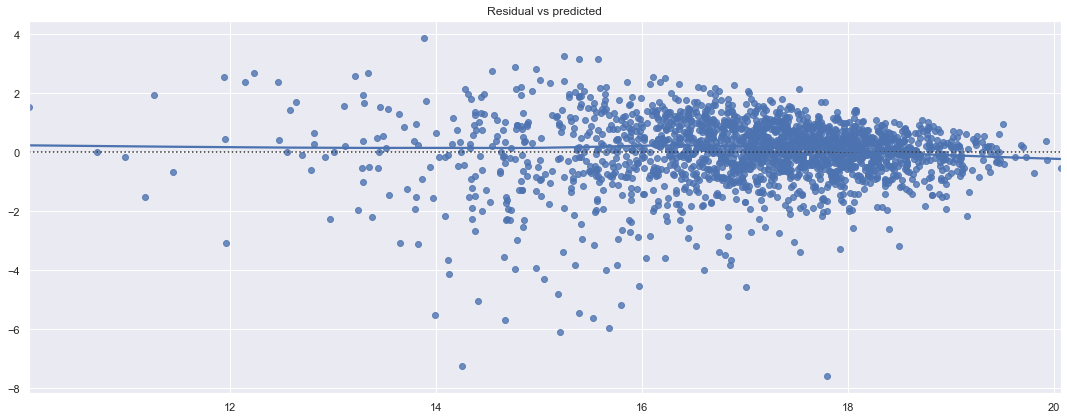

In [89]:
# considering all variables
equation = """
gross_log ~ runtime + year + budget_log + C(audience, Treatment(reference='only_adults')) +
                C(genre, Treatment(reference='Comedy')) + C(director, Treatment(reference='Woody Allen'))
"""
mod = ols(equation, data=df_full)
res = mod.fit()
# print(res.summary())

residuals = df_full['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_full['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

In [90]:
df_results_director = pd.DataFrame({'coeff':res.params.values,
              'pvalue':res.pvalues,
              '[0.025':res.conf_int(alpha=0.05)[0].values,
              '0.975]':res.conf_int(alpha=0.05)[1].values})

df_results_director = df_results_director.loc[df_results_director['pvalue']<= 0.05].sort_values(by='coeff', ascending=False)
df_results_director

coeff        pvalue  \
Intercept                                           16.267077  0.000000e+00   
C(director, Treatment(reference='Woody Allen'))...   2.291653  2.913148e-05   
C(director, Treatment(reference='Woody Allen'))...   2.145192  4.518775e-06   
C(director, Treatment(reference='Woody Allen'))...   2.118045  4.509913e-05   
C(director, Treatment(reference='Woody Allen'))...   2.101467  4.122470e-04   
...                                                       ...           ...   
C(director, Treatment(reference='Woody Allen'))...  -2.661338  3.225592e-02   
C(director, Treatment(reference='Woody Allen'))...  -2.902338  1.159085e-06   
C(genre, Treatment(reference='Comedy'))[T.Romance]  -3.769818  3.441672e-03   
C(director, Treatment(reference='Woody Allen'))...  -5.120095  9.781977e-09   
C(genre, Treatment(reference='Comedy'))[T.Musical]  -5.409196  5.218370e-05   

                                                       [0.025     0.975]  
Intercept                                           15.813797  16.720356  
C(director, Treatment(reference='Woody Allen'))...   1.219336   3.363971  
C(director, Treatment(reference='Woody Allen'))...   1.230719   3.059665  
C(director, Treatment(reference='Woody Allen'))...   1.102428   3.133662  
C(director, Treatment(reference='Woody Allen'))...   0.936866   3.266069  
...                                                       ...        ...  
C(director, Treatment(reference='Woody Allen'))...  -5.097117  -0.225559  
C(director, Treatment(reference='Woody Allen'))...  -4.068758  -1.735919  
C(genre, Treatment(reference='Comedy'))[T.Romance]  -6.293873  -1.245762  
C(director, Treatment(reference='Woody Allen'))...  -6.862517  -3.377673  
C(genre, Treatment(reference='Comedy'))[T.Musical]  -8.024879  -2.793513  

[111 rows x 4 columns]

### QUESTION 6

**¿Con que presupuesto se máximiza el beneficio?**

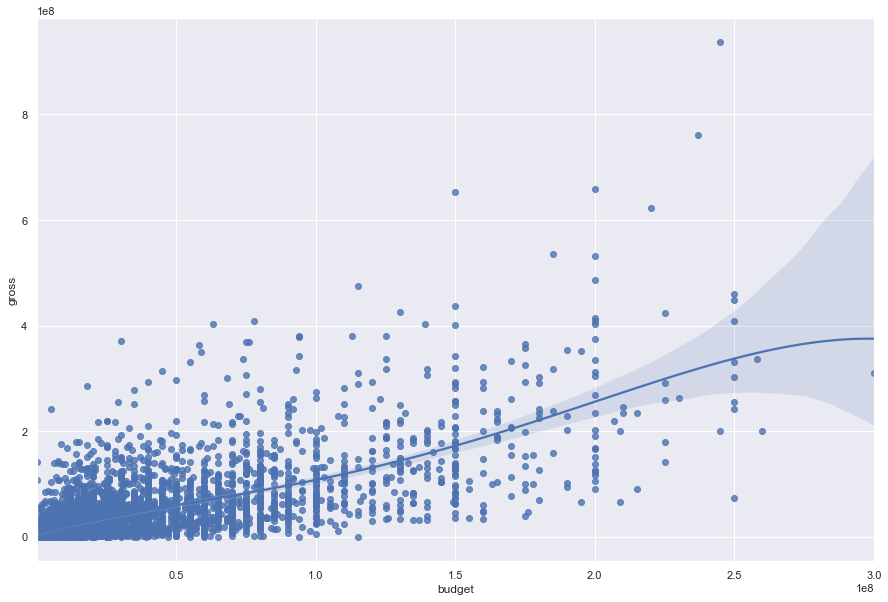

In [91]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

sns.regplot(data=df, x='budget', y='gross', order=4, ax=ax);

In [92]:
df['profit'] = df['gross'] - df['budget']

<AxesSubplot:ylabel='Frequency'>

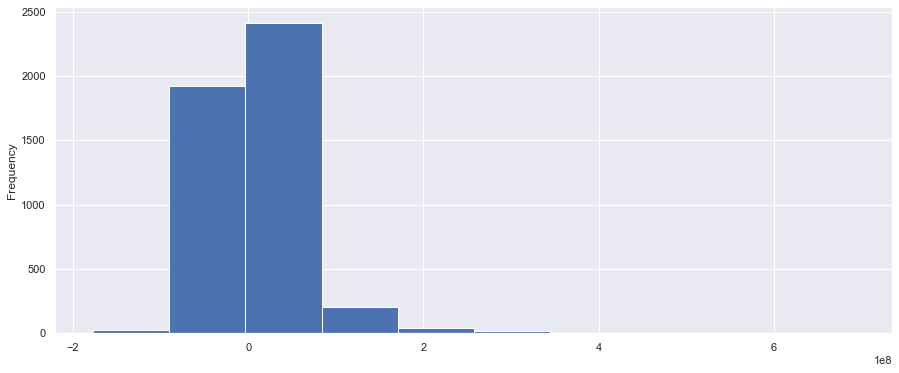

In [93]:
df['profit'].plot.hist(figsize=(15,6))

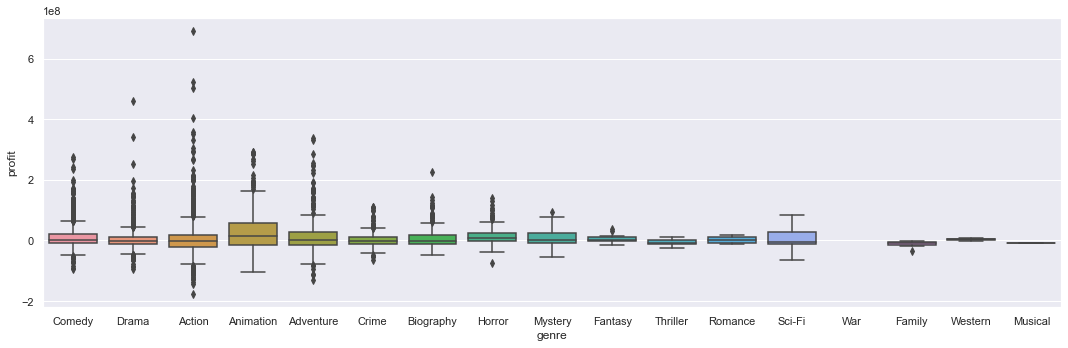

In [94]:
# boxplot by genre
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='genre', y='profit')
plt.tight_layout()  

In [95]:
# summary statistics by genre
df_genre_profit = df[['profit','genre']].groupby('genre').describe()
df_genre_profit.columns = df_genre_profit.columns.droplevel()
df_genre_profit.sort_values(by='50%', ascending=False, inplace=True) # sorting by median (more robust statistic than mean)
df_genre_profit

count          mean           std          min          25%  \
genre                                                                     
Animation   229.0  3.173390e+07  7.768891e+07 -104868170.0 -14613335.00   
Horror      228.0  1.614929e+07  2.907990e+07  -75781132.0  -1958512.00   
Western       2.0  3.259547e+06  7.114135e+06   -1770906.0    744320.50   
Romance       5.0  2.892564e+06  1.323358e+07  -12715709.0  -6958197.00   
Comedy     1310.0  1.188578e+07  3.680375e+07  -95579920.0  -7239342.50   
Fantasy      29.0  4.607509e+06  1.171377e+07  -16486972.0  -2798745.00   
Adventure   291.0  1.744454e+07  6.610672e+07 -129812397.0 -16024155.50   
Mystery      31.0  1.023657e+07  3.181825e+07  -54649629.0  -9610776.00   
Crime       356.0  2.427338e+06  2.513560e+07  -62902875.0 -10985118.25   
Drama       793.0  4.297058e+06  3.906157e+07  -93990787.0 -12163363.00   
Biography   239.0  7.781799e+06  3.578312e+07  -48999955.0 -11815474.50   
Action     1099.0  7.182871e+06  6.385481e+07 -176921900.0 -20703908.00   
Sci-Fi       11.0  7.846870e+06  4.040901e+07  -64928486.0 -12525814.00   
Family        6.0 -1.170469e+07  1.195563e+07  -33631790.0 -14714004.50   
Thriller      8.0 -6.036880e+06  1.132025e+07  -23465431.0 -11603795.25   
Musical       1.0 -9.955243e+06           NaN   -9955243.0  -9955243.00   
War           0.0           NaN           NaN          NaN          NaN   

                  50%          75%          max  
genre                                            
Animation  13359111.0  56445654.00  293384330.0  
Horror      8298118.0  24449751.75  140479099.0  
Western     3259547.0   5774773.50    8290000.0  
Romance     2478370.0  12295645.00   19362712.0  
Comedy      1122621.0  21451162.50  275252182.0  
Fantasy      946600.0  11039458.00   37239856.0  
Adventure    250263.0  26335641.00  339453882.0  
Mystery       18877.0  25426842.50   92536138.0  
Crime      -1713745.0  10032689.25  111742922.0  
Drama      -2319642.0  10555230.00  458672302.0  
Biography  -2427423.0  16871406.00  226959475.0  
Action     -3052213.0  19424038.00  691662225.0  
Sci-Fi     -3399104.0  27634860.50   85646235.0  
Family     -6849142.5  -4811586.25   -1430061.0  
Thriller   -8990878.5   1489608.75   11381956.0  
Musical    -9955243.0  -9955243.00   -9955243.0  
War               NaN          NaN          NaN

### QUESTION 7

**Es mejor estrenar la pelicula en algun mes en concreto?**

In [96]:
df_month = df.dropna()
df_month.shape

(4638, 23)

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     12.87
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           2.02e-24
Time:                        20:52:32   Log-Likelihood:                -9898.3
No. Observations:                4638   AIC:                         1.982e+04
Df Residuals:                    4626   BIC:                         1.990e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         16.2974      0.103    157.

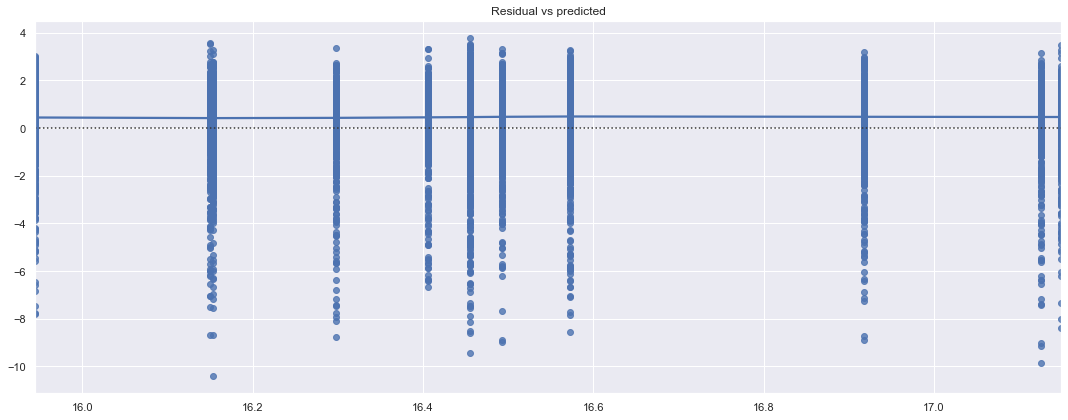

In [97]:
# considering only month
equation = """
gross_log ~ C(month)
"""
mod = ols(equation, data=df_month)
res = mod.fit()
print(res.summary())

residuals = df_month['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_month['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     97.11
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:52:32   Log-Likelihood:                -8801.8
No. Observations:                4638   AIC:                         1.767e+04
Df Residuals:                    4606   BIC:                         1.787e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

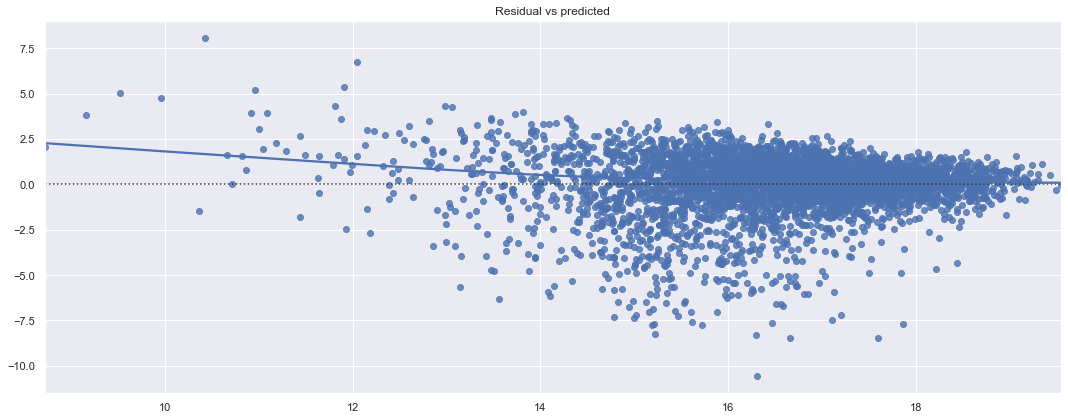

In [98]:
# considering other variables
equation = """
gross_log ~ C(month) + budget_log + C(genre) + C(audience) + runtime + year
"""
mod = ols(equation, data=df_month)
res = mod.fit()
print(res.summary())

residuals = df_month['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_month['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

In [99]:
df_month = df[['month','gross']].groupby('month').mean()

## VISUALIZATIONS

In [100]:
N = 5

s_genre_profit = df_genre_profit.loc[df_genre_gross['count']>=N, '50%']
s_genre_gross = df_genre_gross.loc[s_genre_profit.index, '50%']
df_viz_genre = pd.DataFrame({'gross': s_genre_gross,'profit':s_genre_profit})
df_viz_genre.reset_index(inplace=True)
df_viz_genre.rename(columns={'gross':'Recaudación', 'profit':'Beneficio'}, inplace=True)

df_viz_genre = pd.melt(frame=df_viz_genre, id_vars='genre')
df_viz_genre.sort_values(by='value', ascending=False, inplace=True)
df_viz_genre['value'] = df_viz_genre['value'] / 1000000 

In [101]:
sns.reset_orig() # reset seaborn style

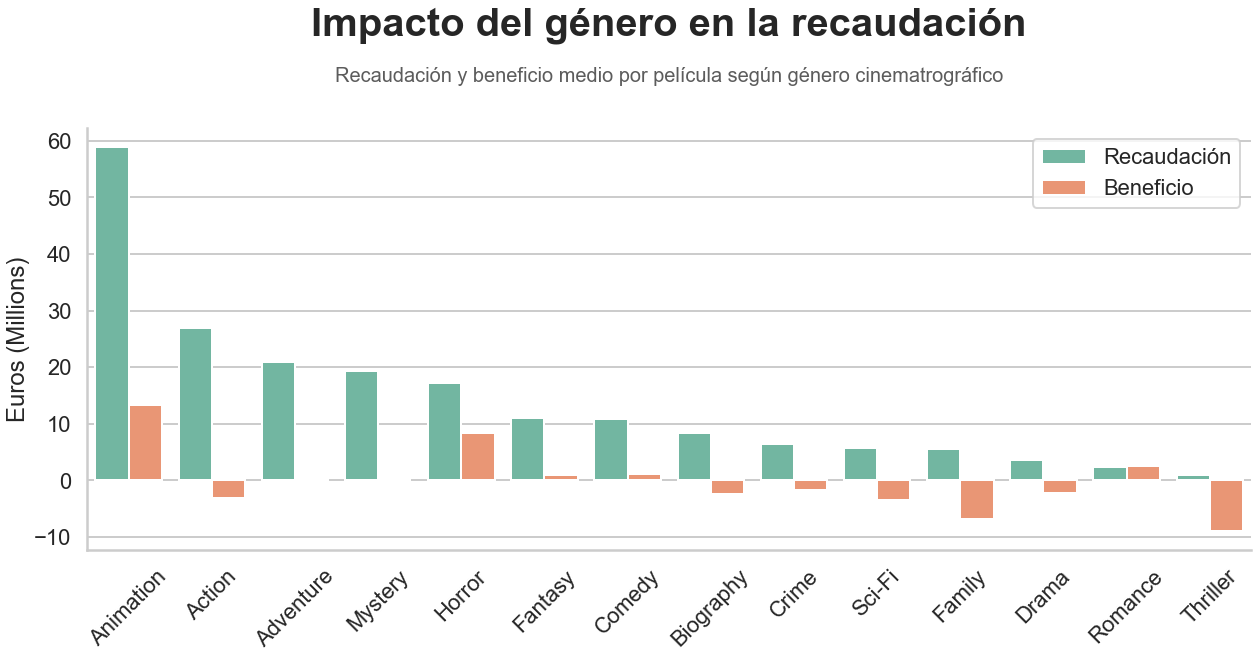

In [102]:
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("Set2")

fig, ax = plt.subplots(1,1, figsize=(18,10))
sns.barplot(data=df_viz_genre, x='genre', y='value', hue='variable', ax=ax)
ax.set_ylabel('Euros (Millions)')
ax.set_xlabel('')
ax.legend(title='')
sns.despine()
plt.xticks(rotation=45)

ax.text(x=0.5, y=1.2, s="Impacto del género en la recaudación",
        fontsize=40, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)
ax.text(x=0.5, y=1.1,
        s="Recaudación y beneficio medio por película según género cinematrográfico",
        fontsize=20, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)


plt.tight_layout();

In [103]:
dfcoeff_genre = coeff_genre.to_frame()
dfcoeff_genre.reset_index(inplace=True)

def get_genre(item):
    return re.findall('.(\w+)]', item)[0]

dfcoeff_genre = dfcoeff_genre.iloc[1:]
dfcoeff_genre['genre'] = dfcoeff_genre['index'].apply(get_genre)
dfcoeff_genre = dfcoeff_genre.drop('index', axis=1)
dfcoeff_genre['coeff'] = (np.exp(dfcoeff_genre['coeff']) - 1)/1 * 100
dfcoeff_genre

coeff      genre
1  389.385823  Animation
2  111.232595  Adventure
3  103.912573     Action
4  -43.034389      Drama
5  -48.810796      Crime
6  -55.239959    Fantasy
7  -93.245747   Thriller
8  -99.656001    Musical

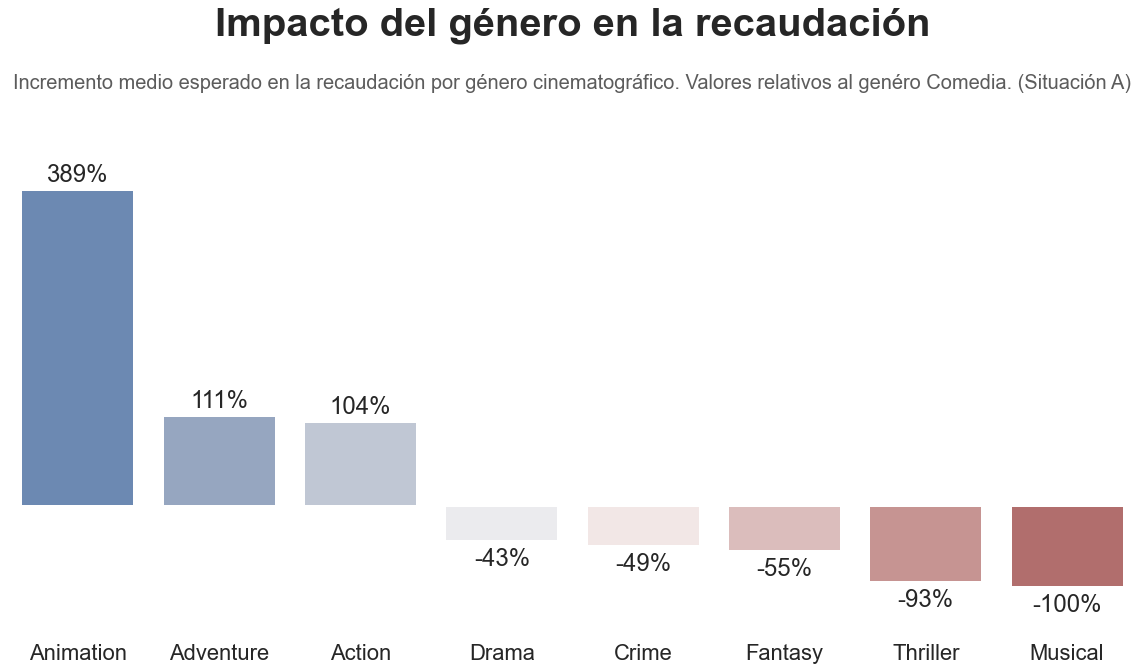

In [104]:
sns.set_style("white")
sns.set_context("poster")
sns.set_palette("Set2")


fig, ax = plt.subplots(1,1, figsize=(18,10))
catp = sns.barplot(data=dfcoeff_genre, x='genre', y='coeff', palette='vlag', ax=ax)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_ylim([-150,450])

ax.set_xlabel('')
sns.despine(left=True, bottom=True)

ax.text(x=0.5, y=1.2, s="Impacto del género en la recaudación",
        fontsize=40, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)
ax.text(x=0.5, y=1.1,
        s="Incremento medio esperado en la recaudación por género cinematográfico. Valores relativos al genéro Comedia. (Situación A)",
        fontsize=20, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x()+p.get_width()/2.,
                height + 10,
                '{:.0f}%'.format(height),
                ha="center")
    else:
        ax.text(p.get_x()+p.get_width()/2.,
                 height - 30,
                '{:.0f}%'.format(height),
                ha="center")        

plt.tight_layout();

In [105]:
dfcoeff_genre_full = coeff_genre_full.to_frame()
dfcoeff_genre_full.reset_index(inplace=True)
dfcoeff_genre_full = dfcoeff_genre_full.iloc[1:9].sort_values(by='coeff', ascending=False)
dfcoeff_genre_full['genre'] = dfcoeff_genre_full['index'].apply(get_genre)
dfcoeff_genre_full = dfcoeff_genre_full.drop('index', axis=1)
dfcoeff_genre_full['coeff'] = (np.exp(dfcoeff_genre_full['coeff']) - 1)/1 * 100
dfcoeff_genre_full

coeff      genre
6  57.639307     Horror
1  37.363448  Animation
2 -32.409736  Biography
3 -36.965815      Crime
4 -40.149896      Drama
5 -74.419776     Family
8 -90.587242   Thriller
7 -99.652444    Musical

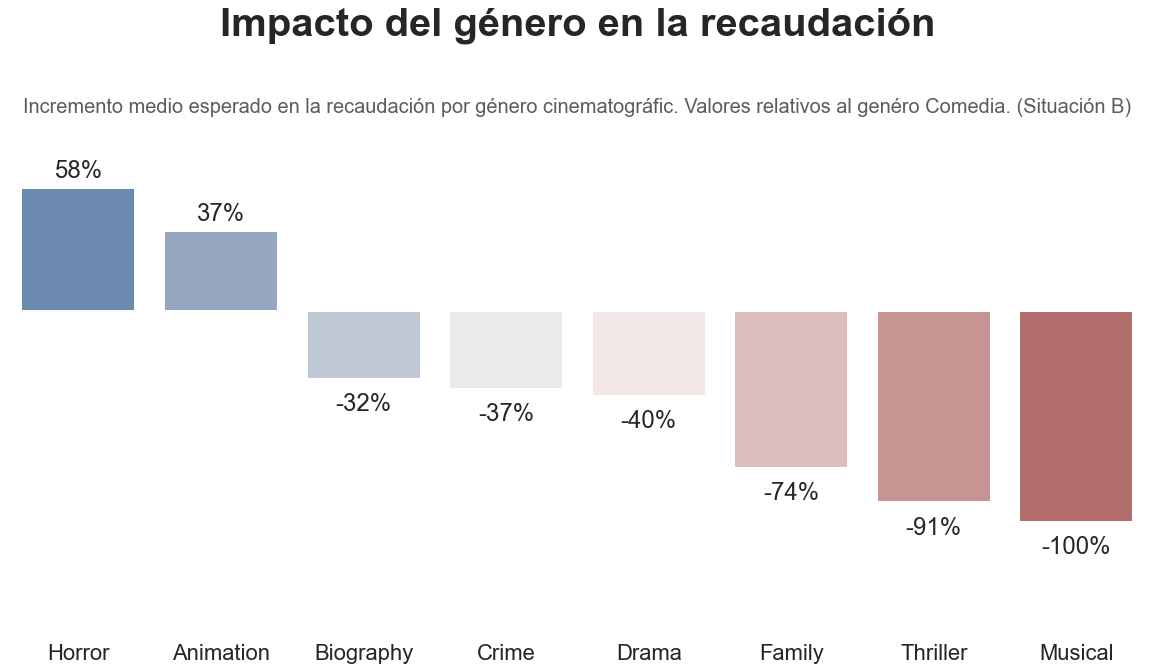

In [106]:
sns.set_style("white")
sns.set_context("poster")


fig, ax = plt.subplots(1,1, figsize=(18,10))
catp = sns.barplot(data=dfcoeff_genre_full, x='genre', y='coeff', palette='vlag', ax=ax)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_ylim([-150,80])

ax.set_xlabel('')
sns.despine(left=True, bottom=True)

ax.text(x=0.5, y=1.2, s="Impacto del género en la recaudación",
        fontsize=40, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)
ax.text(x=0.5, y=1.05,
        s="Incremento medio esperado en la recaudación por género cinematográfic. Valores relativos al genéro Comedia. (Situación B)",
        fontsize=20, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x()+p.get_width()/2.,
                height + 5,
                '{:.0f}%'.format(height),
                ha="center")
    else:
        ax.text(p.get_x()+p.get_width()/2.,
                 height - 15,
                '{:.0f}%'.format(height),
                ha="center")        

plt.tight_layout();

In [107]:
dfviz_stars.reset_index(inplace=True)

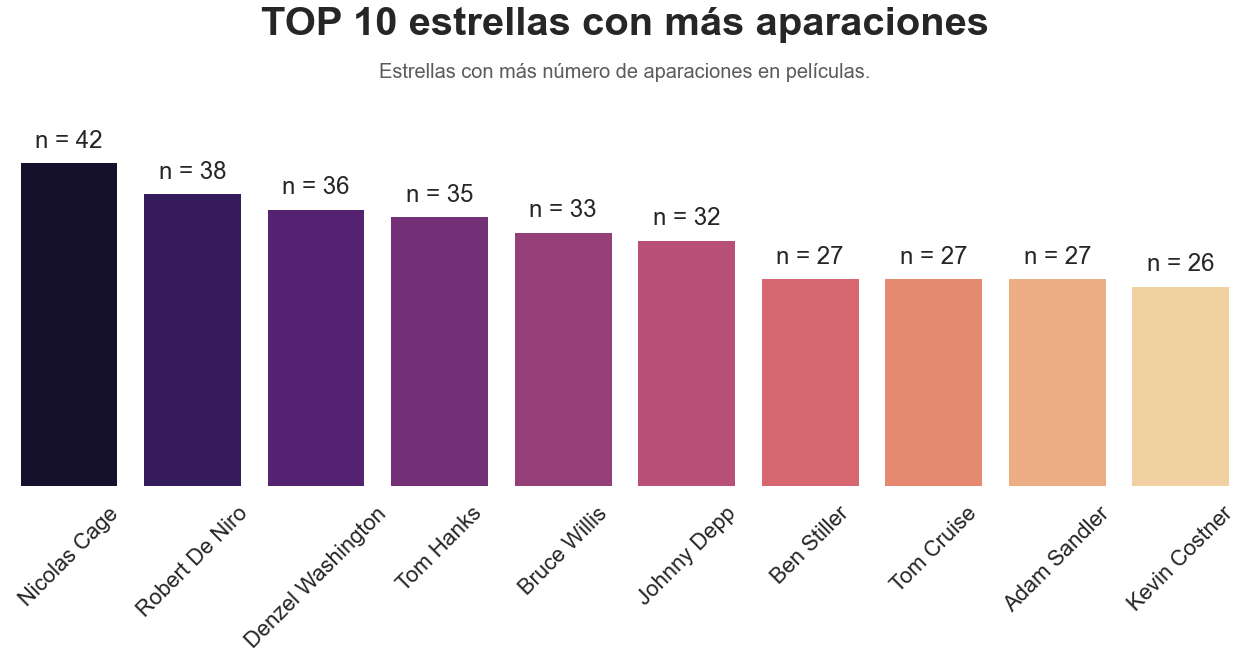

In [108]:
sns.set_style("white")
sns.set_context("poster")


fig, ax = plt.subplots(1,1, figsize=(18,10))
catp = sns.barplot(data=dfviz_stars.iloc[:10], x='star', y='count', palette='magma', ax=ax)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_ylim([0,50])
plt.xticks(rotation=45)

ax.set_xlabel('')
sns.despine(left=True, bottom=True)

ax.text(x=0.5, y=1.15, s="TOP 10 estrellas con más aparaciones",
        fontsize=40, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)
ax.text(x=0.5, y=1.05,
        s="Estrellas con más número de aparaciones en películas.",
        fontsize=20, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 2,
            'n = {:.0f}'.format(height),
            ha="center")     

plt.tight_layout();

In [109]:
df_results_fullstars

coeff    pvalue  \
Intercept                                           16.315298  0.000000   
C(star, Treatment(reference='Nicolas Cage'))[T....   2.148735  0.000057   
C(star, Treatment(reference='Nicolas Cage'))[T....   1.963858  0.001138   
C(star, Treatment(reference='Nicolas Cage'))[T....   1.800577  0.000216   
C(star, Treatment(reference='Nicolas Cage'))[T....   1.797024  0.000776   
...                                                       ...       ...   
C(star, Treatment(reference='Nicolas Cage'))[T....  -2.404770  0.000226   
C(star, Treatment(reference='Nicolas Cage'))[T....  -2.421800  0.000058   
C(star, Treatment(reference='Nicolas Cage'))[T....  -2.459217  0.002671   
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.266380  0.001191   
C(star, Treatment(reference='Nicolas Cage'))[T....  -4.087705  0.000040   

                                                       [0.025     0.975]  
Intercept                                           15.859393  16.771202  
C(star, Treatment(reference='Nicolas Cage'))[T....   1.103198   3.194271  
C(star, Treatment(reference='Nicolas Cage'))[T....   0.781798   3.145918  
C(star, Treatment(reference='Nicolas Cage'))[T....   0.847569   2.753586  
C(star, Treatment(reference='Nicolas Cage'))[T....   0.749982   2.844066  
...                                                       ...        ...  
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.681426  -1.128113  
C(star, Treatment(reference='Nicolas Cage'))[T....  -3.600395  -1.243205  
C(star, Treatment(reference='Nicolas Cage'))[T....  -4.063253  -0.855181  
C(star, Treatment(reference='Nicolas Cage'))[T....  -5.240237  -1.292522  
C(star, Treatment(reference='Nicolas Cage'))[T....  -6.035674  -2.139736  

[65 rows x 4 columns]

In [110]:
viz_fullstars = df_results_fullstars.iloc[1:]

N = 5
viz_fullstars = viz_fullstars.iloc[:N]
viz_fullstars['coeff'] = (np.exp(viz_fullstars['coeff']) - 1)/1 * 100
viz_fullstars.reset_index(inplace=True)

def get_name(item):
    return re.findall('.(\w+\s*\w+)]', item)[0]

viz_fullstars['star'] = viz_fullstars['index'].apply(get_name)

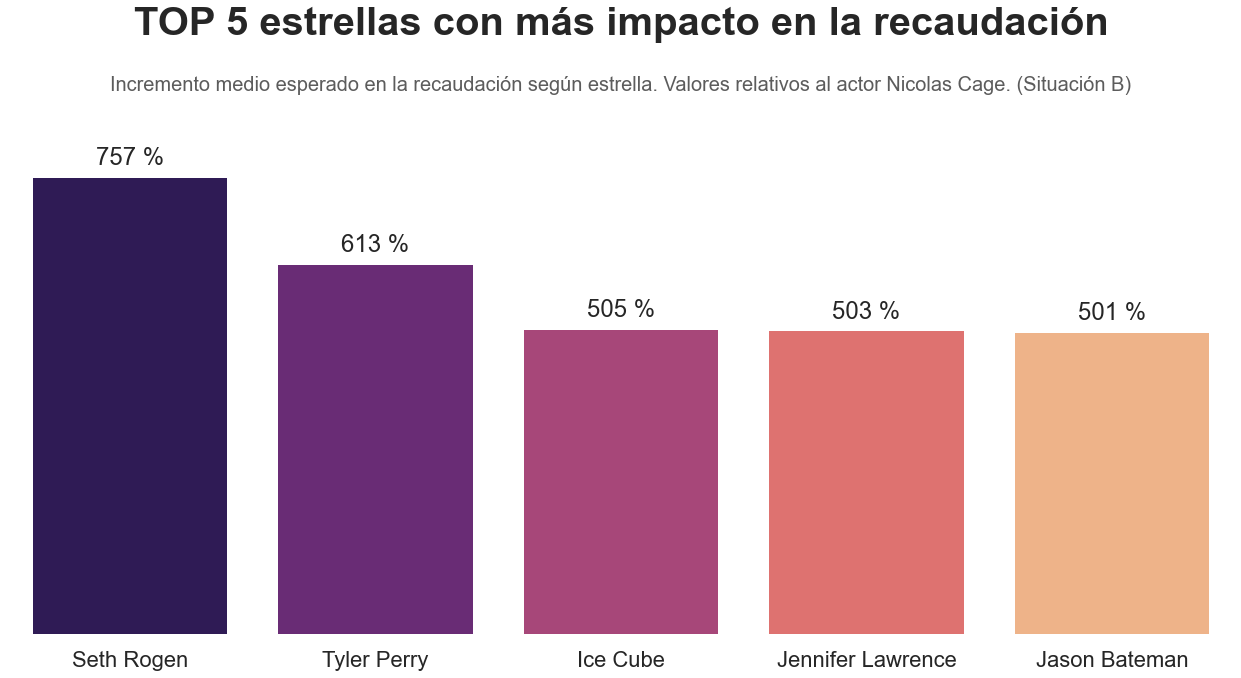

In [111]:
sns.set_style("white")
sns.set_context("poster")

fig, ax = plt.subplots(1,1, figsize=(18,10))
catp = sns.barplot(data=viz_fullstars, x='star', y='coeff', palette='magma', ax=ax)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_ylim([0,850])

ax.set_xlabel('')
sns.despine(left=True, bottom=True)

ax.text(x=0.5, y=1.15, s="TOP 5 estrellas con más impacto en la recaudación",
        fontsize=40, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)
ax.text(x=0.5, y=1.05,
        s="Incremento medio esperado en la recaudación según estrella. Valores relativos al actor Nicolas Cage. (Situación B)",
        fontsize=20, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 20,
            '{:.0f} %'.format(height),
            ha="center")     

plt.tight_layout();

In [112]:
N = 10
viz_director = df_director.sort_values(by='count',ascending=False)[:N]
viz_director.reset_index(inplace=True)
viz_director

director          mean      median           sum  count
0        Woody Allen  1.220572e+07  10506939.0  4.027888e+08     33
1     Clint Eastwood  6.386145e+07  37398697.0  1.532675e+09     24
2  Steven Soderbergh  4.948705e+07  24741700.0  1.039228e+09     21
3   Steven Spielberg  1.376521e+08  96067179.0  2.890693e+09     21
4         Ron Howard  8.629145e+07  58076851.5  1.725829e+09     20
5       Ridley Scott  7.539157e+07  47398413.0  1.432440e+09     19
6    Joel Schumacher  4.677893e+07  35193167.0  8.887996e+08     19
7          Spike Lee  1.862825e+07  13350421.5  3.353085e+08     18
8     Barry Levinson  4.018621e+07  31215831.5  7.233518e+08     18
9       Oliver Stone  4.499211e+07  43848100.0  7.648659e+08     17

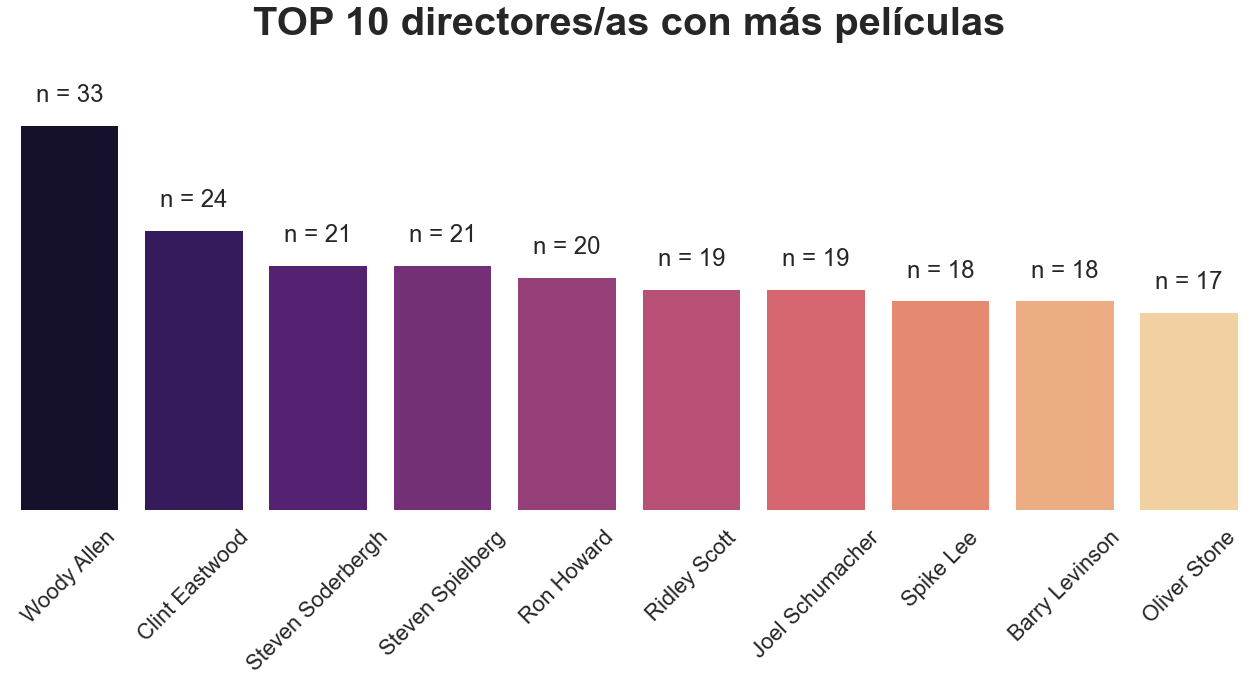

In [113]:
sns.set_style("white")
sns.set_context("poster")


fig, ax = plt.subplots(1,1, figsize=(18,10))
catp = sns.barplot(data=viz_director.iloc[:10], x='director', y='count', palette='magma', ax=ax)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_ylim([0,40])
plt.xticks(rotation=45)

ax.set_xlabel('')
sns.despine(left=True, bottom=True)

ax.text(x=0.5, y=1, s="TOP 10 directores/as con más películas",
        fontsize=40, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 2,
            'n = {:.0f}'.format(height),
            ha="center")     

plt.tight_layout();

In [114]:
viz_director = df_results_director.iloc[1:]

N = 5
viz_director = viz_director.iloc[:N]
viz_director['coeff'] = (np.exp(viz_director['coeff']) - 1)/1 * 100
viz_director.reset_index(inplace=True)

viz_director['director'] = viz_director['index'].apply(get_name)

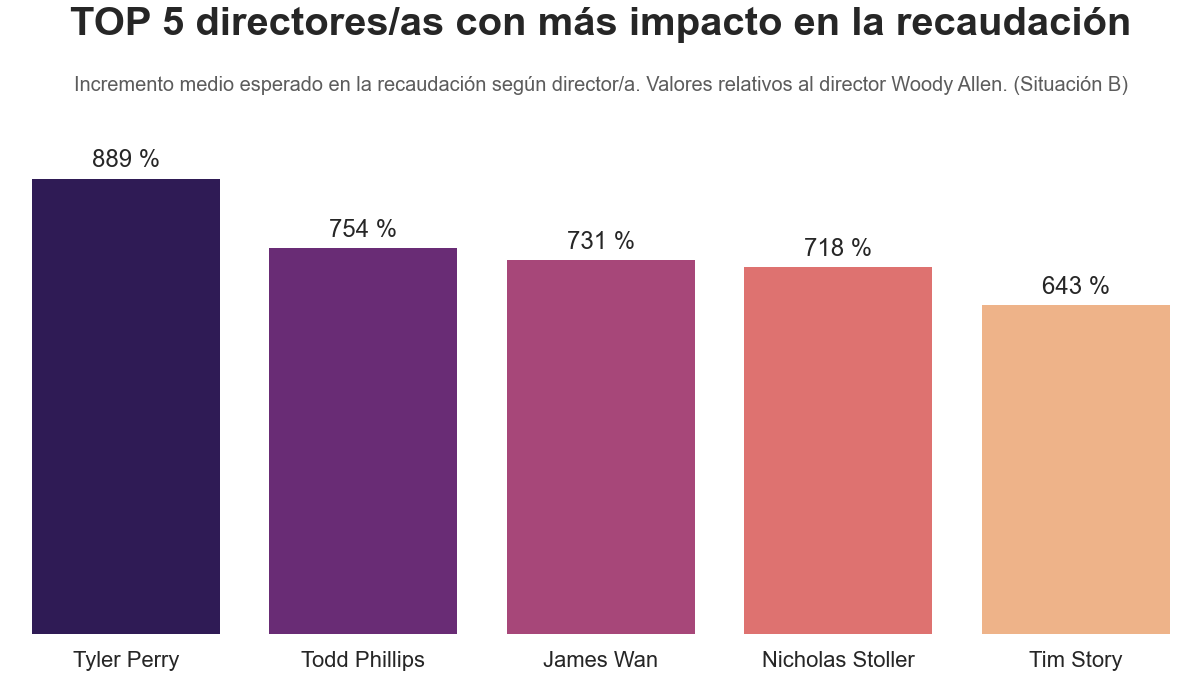

In [115]:
sns.set_style("white")
sns.set_context("poster")


fig, ax = plt.subplots(1,1, figsize=(18,10))
catp = sns.barplot(data=viz_director, x='director', y='coeff', palette='magma', ax=ax)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_ylim([0,1000])

ax.set_xlabel('')
sns.despine(left=True, bottom=True)

ax.text(x=0.5, y=1.15, s="TOP 5 directores/as con más impacto en la recaudación",
        fontsize=40, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)
ax.text(x=0.5, y=1.05,
        s="Incremento medio esperado en la recaudación según director/a. Valores relativos al director Woody Allen. (Situación B)",
        fontsize=20, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 20,
            '{:.0f} %'.format(height),
            ha="center")     

plt.tight_layout();

In [116]:
df_month.reset_index(inplace=True)
df_month['month'] = df_month['month'].astype('int')
df_month.sort_values(by='month', inplace=True)
df_month['gross'] = df_month['gross'] / 1000000
df_month['month_name'] = pd.to_datetime(df_month['month'], format='%m')

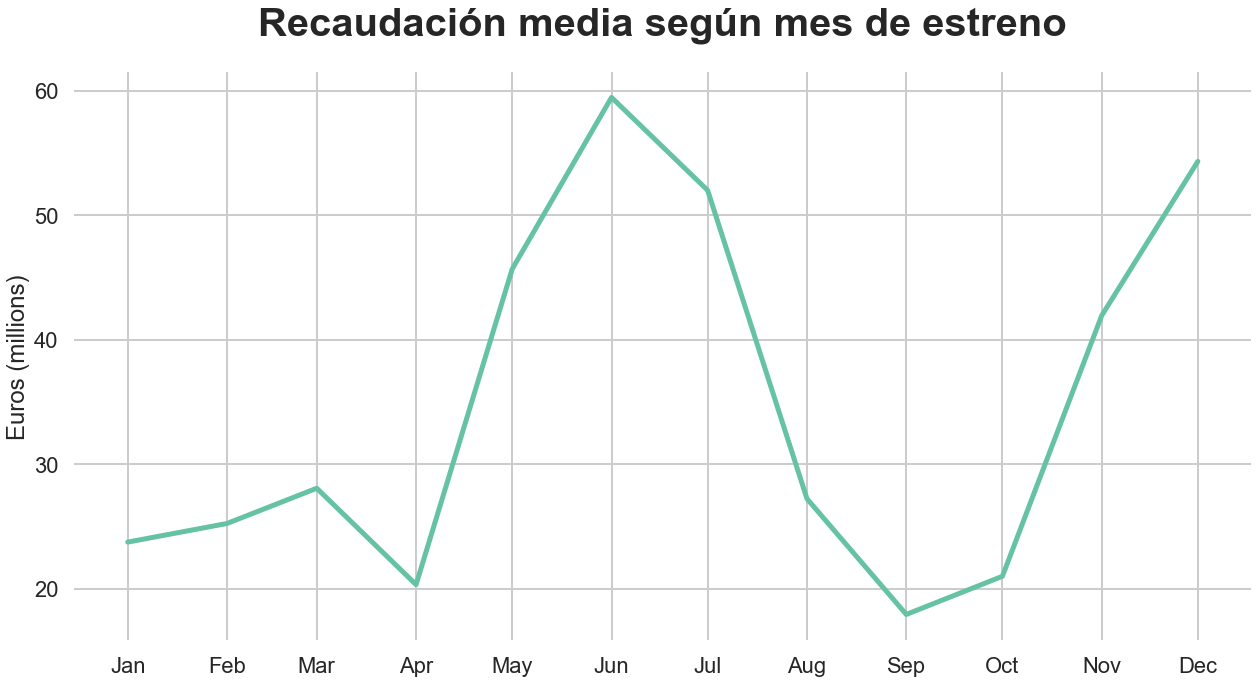

In [117]:
sns.set_style("whitegrid")
sns.set_context("poster")


fig, ax = plt.subplots(1,1, figsize=(18,10))
catp = sns.lineplot(data=df_month, x='month_name', y='gross', linewidth = 5)
ax.set_ylabel('Euros (millions)')

# display the month in the x-axis
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)

ax.set_xlabel('')
sns.despine(bottom=True, left=True)

ax.text(x=0.5, y=1.05, s="Recaudación media según mes de estreno",
        fontsize=40, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)


plt.tight_layout();

# FINAL